In [1]:
if 'libraries_imported' not in globals():
    libraries_imported = False

if libraries_imported == False:
    import os
    import sys
    from collections import Counter
    from datetime import datetime, timedelta

    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import plotly.graph_objects as go

    from scipy.signal import butter, filtfilt

    import joblib

    from keras_tuner import RandomSearch, HyperModel

    from sklearn.preprocessing import StandardScaler, RobustScaler
    from sklearn.model_selection import (
        train_test_split,
        TimeSeriesSplit,
        RandomizedSearchCV,
    )
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.utils.class_weight import compute_class_weight
    from sklearn.metrics import (
        mean_squared_error,
        r2_score,
        mean_absolute_error,
        accuracy_score,
        precision_recall_fscore_support,
        classification_report,
        confusion_matrix,
        ConfusionMatrixDisplay,
    )

    from imblearn.over_sampling import SMOTE
    from xgboost import XGBClassifier


2025-12-17 11:29:25.239466: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-17 11:29:25.239747: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-17 11:29:25.271583: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2025-12-17 11:29:26.175827: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-17 11:29:26.176033: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


Inspect Feature importances


Basic feature engineering -- Add mvoing averages


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from collections import Counter
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import joblib
import matplotlib.pyplot as plt

# =============================
# Constants
# =============================
DROP_COLUMNS_LIVE_ONLY = ["h2s_ppm", "t1_cod", "t1_olr", "fostac"]

# =============================
# Setup portable directories
# =============================
BASE_DIR = Path.cwd()
MODEL_DIR = BASE_DIR / "model_params"
RESULTS_DIR = BASE_DIR / "results"

MODEL_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# =============================
# Dataset 1
# =============================
dataset1_df = pd.read_csv("datasets/s_dataset1.csv")

# Detect a date-like column
candidates = [c for c in ["datetime", "date", "day_number"] if c in dataset1_df.columns]
if not candidates:
    raise ValueError("No 'date', 'datetime', or 'day_number' column found in dataset 1.")
src_col = candidates[0]

# Build a clean 'date' column
if src_col == "day_number":
    base_date = pd.Timestamp("2020-01-01")  # adjust as needed
    dataset1_df["date"] = base_date + pd.to_timedelta(dataset1_df[src_col], unit="D")
else:
    dataset1_df["date"] = pd.to_datetime(dataset1_df[src_col], dayfirst=True, errors="coerce")

# Drop unwanted columns except the final 'date'
cols_to_drop = ["index", "f/m_ratio", "fos", "tac"]
dataset1_df.drop(columns=[c for c in cols_to_drop if c in dataset1_df.columns], inplace=True)

# Drop live-only columns (if present)
dataset1_df.drop(
    columns=[c for c in DROP_COLUMNS_LIVE_ONLY if c in dataset1_df.columns],
    inplace=True
)

if src_col != "date" and src_col in dataset1_df.columns:
    dataset1_df.drop(columns=[src_col], inplace=True)

dataset1_df = dataset1_df.drop_duplicates()

# =============================
# Dataset 2
# =============================
dataset2_df = pd.read_csv("datasets/c_dataset2.csv")

# Detect a date-like column
candidates = [c for c in ["datetime", "date", "day_number"] if c in dataset2_df.columns]
if not candidates:
    raise ValueError("No 'date', 'datetime', or 'day_number' column found in dataset 2.")
src_col = candidates[0]

# Convert to datetime or compute from day_number
if src_col == "day_number":
    base_date = pd.Timestamp("2020-01-01")  # adjust as needed
    dataset2_df["date"] = base_date + pd.to_timedelta(dataset2_df[src_col], unit="D")
else:
    dataset2_df["date"] = pd.to_datetime(dataset2_df[src_col], dayfirst=True, errors="coerce")

# Group and clean
dataset2_df = dataset2_df.groupby("date").mean(numeric_only=True)
dataset2_df = dataset2_df.drop_duplicates()
dataset2_df.reset_index(inplace=True)

# Drop live-only columns (if present)
dataset2_df.drop(
    columns=[c for c in DROP_COLUMNS_LIVE_ONLY if c in dataset2_df.columns],
    inplace=True
)

# Scale methane percentage if present
if "methane_percentage" in dataset2_df.columns:
    dataset2_df["methane_percentage"] *= 100


/tmp/ipykernel_8/4051726223.py:49: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataset1_df["date"] = pd.to_datetime(dataset1_df[src_col], dayfirst=True, errors="coerce")


In [3]:
# ------------------------------
# Imports
# ------------------------------
import os
import shutil
import random
import joblib
import numpy as np
import pandas as pd

from collections import Counter
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score

from imblearn.over_sampling import SMOTE
import xgboost as xgb


# ------------------------------
# Config
# ------------------------------
TARGET = "eq_cod"
DATE_COL = "date"
OUTDIR = "transfer_learning_model_params"

PRETRAIN_PCTS = [0.3, 0.4, 0.5, 0.6, 0.7]

CLASS_LABELS = ["LL", "ML", "MH", "HH"]

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

MAX_FOLDS = 10
BIN_ROUND_BASE = 500
EPS = 1e-9

MAX_SAMPLE_ATTEMPTS = 200
MAX_SPLIT_ATTEMPTS = 50


# ------------------------------
# Reset output directory
# ------------------------------
if os.path.exists(OUTDIR):
    print(f"[RESET] Removing existing directory: {OUTDIR}")
    shutil.rmtree(OUTDIR)

os.makedirs(OUTDIR, exist_ok=True)
print(f"[RESET] Created clean directory: {OUTDIR}")


# ------------------------------
# Helpers
# ------------------------------
def keep_random_percent(df, keep_percent, seed):
    if keep_percent >= 1.0:
        return df.copy()
    n_keep = max(1, int(len(df) * keep_percent))
    return df.sample(n=n_keep, random_state=seed).reset_index(drop=True)


def round_to_nearest(x, base=500):
    return base * round(float(x) / base)


def make_bins_from_dataset(df, target_col, n_bins=4, base=BIN_ROUND_BASE):
    dmin = float(df[target_col].min())
    dmax = float(df[target_col].max())

    bins = np.linspace(dmin, dmax, n_bins + 1)

    if base and base > 0:
        bins = np.array([round_to_nearest(b, base) for b in bins], dtype=float)
        bins[0] = min(bins[0], dmin)
        bins[-1] = max(bins[-1], dmax)

    for i in range(1, len(bins)):
        if bins[i] <= bins[i - 1]:
            bins[i] = bins[i - 1] + EPS

    bins[-1] = max(bins[-1], dmax + EPS)
    return bins


def ensure_dir(path):
    os.makedirs(path, exist_ok=True)


# ------------------------------
# Main training pipeline
# ------------------------------
def run_pipeline_for_dataset(df, dataset_tag, keep_percent):
    print(f"\n=== Running pipeline for {dataset_tag} (keep_percent={keep_percent}) ===")

    if DATE_COL not in df.columns or TARGET not in df.columns:
        raise ValueError(f"[{dataset_tag}] Missing required columns")

    df = df.sort_values(DATE_COL).reset_index(drop=True)

    # ------------------------------
    # Re-sample until dataset is stratifiable
    # ------------------------------
    for attempt in range(MAX_SAMPLE_ATTEMPTS):
        df_try = keep_random_percent(df, keep_percent, SEED + attempt)
        df_try = df_try.ffill()
        df_try = df_try.dropna(subset=[TARGET])

        bins = make_bins_from_dataset(df_try, TARGET)
        df_try["fostac_category"] = pd.cut(
            df_try[TARGET], bins=bins, labels=CLASS_LABELS, include_lowest=True
        )
        df_try["fostac_category"] = (
            df_try["fostac_category"]
            .astype("category")
            .cat.set_categories(CLASS_LABELS, ordered=True)
        )
        df_try.dropna(subset=["fostac_category"], inplace=True)

        X = df_try.select_dtypes(include=[np.number]).drop(columns=[TARGET])
        y = pd.Series(df_try["fostac_category"].cat.codes)

        counts = Counter(y)
        if len(counts) == 4 and min(counts.values()) >= 2:
            print(f"[{dataset_tag}] Class distribution (sampled): {counts}")
            break
    else:
        raise RuntimeError(f"[{dataset_tag}] Could not get valid stratified sample")

    # ------------------------------
    # Retry stratified split
    # ------------------------------
    for attempt in range(MAX_SPLIT_ATTEMPTS):
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, random_state=SEED + attempt, stratify=y
        )
        if len(np.unique(y_train)) == 4:
            print(f"[{dataset_tag}] Class distribution (train): {Counter(y_train)}")
            break
    else:
        raise RuntimeError(f"[{dataset_tag}] Could not get valid stratified split")

    # ------------------------------
    # Scaling + SMOTE
    # ------------------------------
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    min_count = min(Counter(y_train).values())
    if min_count >= 2:
        sm = SMOTE(random_state=SEED, k_neighbors=min(5, min_count - 1))
        X_train_scaled, y_train = sm.fit_resample(X_train_scaled, y_train)
        y_train = pd.Series(y_train)
        print(f"[{dataset_tag}] SMOTE applied: {Counter(y_train)}")

    # ------------------------------
    # CV + model selection
    # ------------------------------
    param_grid = [
        {"max_depth": 3, "learning_rate": 0.1, "n_estimators": 200},
        {"max_depth": 4, "learning_rate": 0.08, "n_estimators": 300},
        {"max_depth": 5, "learning_rate": 0.05, "n_estimators": 400},
    ]

    skf = StratifiedKFold(
        n_splits=min(MAX_FOLDS, min_count),
        shuffle=True,
        random_state=SEED,
    )

    best_score = -1
    best_params = None

    for params in param_grid:
        scores = []
        for tr, te in skf.split(X_train_scaled, y_train):
            model = xgb.XGBClassifier(
                objective="multi:softprob",
                num_class=4,
                eval_metric="mlogloss",
                random_state=SEED,
                nthread=1,
                **params,
            )
            model.fit(X_train_scaled[tr], y_train.iloc[tr])
            preds = model.predict(X_train_scaled[te])
            scores.append(accuracy_score(y_train.iloc[te], preds))

        score = np.mean(scores)
        print(f"[{dataset_tag}] Params {params} -> CV acc {score:.4f}")

        if score > best_score:
            best_score = score
            best_params = params

    print(f"[{dataset_tag}] Best params: {best_params}")

    # ------------------------------
    # Final training + save
    # ------------------------------
    model = xgb.XGBClassifier(
        objective="multi:softprob",
        num_class=4,
        eval_metric="mlogloss",
        random_state=SEED,
        nthread=1,
        **best_params,
    )
    model.fit(X_train_scaled, y_train)

    val_acc = accuracy_score(y_val, model.predict(X_val_scaled))
    print(f"[{dataset_tag}] Holdout accuracy: {val_acc:.4f}")

    base = os.path.join(OUTDIR, dataset_tag)
    ensure_dir(base)

    joblib.dump(model, f"{base}/{dataset_tag}_best_model.pkl")
    joblib.dump(scaler, f"{base}/{dataset_tag}_scaler.pkl")
    joblib.dump(list(X.columns), f"{base}/{dataset_tag}_feature_cols.pkl")
    np.save(f"{base}/{dataset_tag}_bins.npy", bins)
    joblib.dump(CLASS_LABELS, f"{base}/{dataset_tag}_labels.pkl")


# ------------------------------
# Driver
# ------------------------------
for pct in PRETRAIN_PCTS:
    run_pipeline_for_dataset(dataset1_df, f"D1_p{int(pct*100)}", pct)
    run_pipeline_for_dataset(dataset2_df, f"D2_p{int(pct*100)}", pct)


[RESET] Removing existing directory: transfer_learning_model_params
[RESET] Created clean directory: transfer_learning_model_params

=== Running pipeline for D1_p30 (keep_percent=0.3) ===
[D1_p30] Class distribution (sampled): Counter({1: 17, 3: 10, 2: 6, 0: 6})
[D1_p30] Class distribution (train): Counter({1: 13, 3: 8, 0: 5, 2: 5})
[D1_p30] SMOTE applied: Counter({0: 13, 1: 13, 2: 13, 3: 13})
[D1_p30] Params {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 200} -> CV acc 0.6745


[D1_p30] Params {'max_depth': 4, 'learning_rate': 0.08, 'n_estimators': 300} -> CV acc 0.6945


[D1_p30] Params {'max_depth': 5, 'learning_rate': 0.05, 'n_estimators': 400} -> CV acc 0.6545
[D1_p30] Best params: {'max_depth': 4, 'learning_rate': 0.08, 'n_estimators': 300}
[D1_p30] Holdout accuracy: 0.6250

=== Running pipeline for D2_p30 (keep_percent=0.3) ===
[D2_p30] Class distribution (sampled): Counter({0: 6, 3: 4, 1: 4, 2: 2})
[D2_p30] Class distribution (train): Counter({0: 4, 1: 3, 3: 3, 2: 2})
[D2_p30] SMOTE applied: Counter({0: 4, 1: 4, 2: 4, 3: 4})
[D2_p30] Params {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 200} -> CV acc 0.6250
[D2_p30] Params {'max_depth': 4, 'learning_rate': 0.08, 'n_estimators': 300} -> CV acc 0.6250


[D2_p30] Params {'max_depth': 5, 'learning_rate': 0.05, 'n_estimators': 400} -> CV acc 0.6250
[D2_p30] Best params: {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 200}
[D2_p30] Holdout accuracy: 0.2500

=== Running pipeline for D1_p40 (keep_percent=0.4) ===
[D1_p40] Class distribution (sampled): Counter({1: 23, 2: 11, 3: 11, 0: 7})
[D1_p40] Class distribution (train): Counter({1: 18, 2: 9, 3: 9, 0: 5})
[D1_p40] SMOTE applied: Counter({0: 18, 2: 18, 1: 18, 3: 18})
[D1_p40] Params {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 200} -> CV acc 0.8476


[D1_p40] Params {'max_depth': 4, 'learning_rate': 0.08, 'n_estimators': 300} -> CV acc 0.7924


[D1_p40] Params {'max_depth': 5, 'learning_rate': 0.05, 'n_estimators': 400} -> CV acc 0.8057
[D1_p40] Best params: {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 200}
[D1_p40] Holdout accuracy: 0.7273

=== Running pipeline for D2_p40 (keep_percent=0.4) ===
[D2_p40] Class distribution (sampled): Counter({0: 8, 1: 6, 2: 4, 3: 4})
[D2_p40] Class distribution (train): Counter({0: 6, 1: 5, 3: 3, 2: 3})
[D2_p40] SMOTE applied: Counter({3: 6, 1: 6, 0: 6, 2: 6})
[D2_p40] Params {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 200} -> CV acc 0.7083
[D2_p40] Params {'max_depth': 4, 'learning_rate': 0.08, 'n_estimators': 300} -> CV acc 0.7083


[D2_p40] Params {'max_depth': 5, 'learning_rate': 0.05, 'n_estimators': 400} -> CV acc 0.7083
[D2_p40] Best params: {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 200}
[D2_p40] Holdout accuracy: 0.6000

=== Running pipeline for D1_p50 (keep_percent=0.5) ===
[D1_p50] Class distribution (sampled): Counter({1: 29, 3: 17, 2: 12, 0: 8})
[D1_p50] Class distribution (train): Counter({1: 23, 3: 13, 2: 10, 0: 6})
[D1_p50] SMOTE applied: Counter({3: 23, 0: 23, 1: 23, 2: 23})


[D1_p50] Params {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 200} -> CV acc 0.7806


[D1_p50] Params {'max_depth': 4, 'learning_rate': 0.08, 'n_estimators': 300} -> CV acc 0.7694


[D1_p50] Params {'max_depth': 5, 'learning_rate': 0.05, 'n_estimators': 400} -> CV acc 0.7486
[D1_p50] Best params: {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 200}
[D1_p50] Holdout accuracy: 0.5000

=== Running pipeline for D2_p50 (keep_percent=0.5) ===
[D2_p50] Class distribution (sampled): Counter({0: 11, 1: 7, 2: 5, 3: 4})
[D2_p50] Class distribution (train): Counter({0: 9, 1: 5, 2: 4, 3: 3})
[D2_p50] SMOTE applied: Counter({2: 9, 0: 9, 1: 9, 3: 9})
[D2_p50] Params {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 200} -> CV acc 0.7500
[D2_p50] Params {'max_depth': 4, 'learning_rate': 0.08, 'n_estimators': 300} -> CV acc 0.7500


[D2_p50] Params {'max_depth': 5, 'learning_rate': 0.05, 'n_estimators': 400} -> CV acc 0.7500
[D2_p50] Best params: {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 200}
[D2_p50] Holdout accuracy: 0.8333

=== Running pipeline for D1_p60 (keep_percent=0.6) ===
[D1_p60] Class distribution (sampled): Counter({1: 35, 3: 20, 2: 14, 0: 10})
[D1_p60] Class distribution (train): Counter({1: 28, 3: 16, 2: 11, 0: 8})
[D1_p60] SMOTE applied: Counter({3: 28, 1: 28, 0: 28, 2: 28})


[D1_p60] Params {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 200} -> CV acc 0.7679


[D1_p60] Params {'max_depth': 4, 'learning_rate': 0.08, 'n_estimators': 300} -> CV acc 0.7679


[D1_p60] Params {'max_depth': 5, 'learning_rate': 0.05, 'n_estimators': 400} -> CV acc 0.7679
[D1_p60] Best params: {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 200}
[D1_p60] Holdout accuracy: 0.4375

=== Running pipeline for D2_p60 (keep_percent=0.6) ===
[D2_p60] Class distribution (sampled): Counter({0: 14, 1: 8, 3: 6, 2: 5})
[D2_p60] Class distribution (train): Counter({0: 11, 1: 6, 3: 5, 2: 4})
[D2_p60] SMOTE applied: Counter({3: 11, 0: 11, 1: 11, 2: 11})
[D2_p60] Params {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 200} -> CV acc 0.7727


[D2_p60] Params {'max_depth': 4, 'learning_rate': 0.08, 'n_estimators': 300} -> CV acc 0.7727
[D2_p60] Params {'max_depth': 5, 'learning_rate': 0.05, 'n_estimators': 400} -> CV acc 0.7727
[D2_p60] Best params: {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 200}
[D2_p60] Holdout accuracy: 0.4286

=== Running pipeline for D1_p70 (keep_percent=0.7) ===
[D1_p70] Class distribution (sampled): Counter({1: 43, 3: 22, 2: 16, 0: 11})
[D1_p70] Class distribution (train): Counter({1: 34, 3: 17, 2: 13, 0: 9})
[D1_p70] SMOTE applied: Counter({2: 34, 3: 34, 1: 34, 0: 34})


[D1_p70] Params {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 200} -> CV acc 0.7861


[D1_p70] Params {'max_depth': 4, 'learning_rate': 0.08, 'n_estimators': 300} -> CV acc 0.7713


[D1_p70] Params {'max_depth': 5, 'learning_rate': 0.05, 'n_estimators': 400} -> CV acc 0.7787
[D1_p70] Best params: {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 200}
[D1_p70] Holdout accuracy: 0.6316

=== Running pipeline for D2_p70 (keep_percent=0.7) ===
[D2_p70] Class distribution (sampled): Counter({0: 15, 1: 10, 3: 7, 2: 6})
[D2_p70] Class distribution (train): Counter({0: 12, 1: 8, 2: 5, 3: 5})
[D2_p70] SMOTE applied: Counter({0: 12, 2: 12, 3: 12, 1: 12})
[D2_p70] Params {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 200} -> CV acc 0.7533


[D2_p70] Params {'max_depth': 4, 'learning_rate': 0.08, 'n_estimators': 300} -> CV acc 0.7533


[D2_p70] Params {'max_depth': 5, 'learning_rate': 0.05, 'n_estimators': 400} -> CV acc 0.7533
[D2_p70] Best params: {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 200}
[D2_p70] Holdout accuracy: 0.6250


In [4]:
# ===== Baseline (transfer learning + scaler switchable) =====
# Random train/validation split (no temporal ordering)
# Updated: sweep ONLY pretrained variants that exist on disk

import os, gc, random
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from imblearn.over_sampling import SMOTE
import xgboost as xgb

# ------------------ Config ------------------
OUTDIR_BASE = "transfer_learning_model_params/baseline"
os.makedirs(OUTDIR_BASE, exist_ok=True)

BASE_PRETRAIN_DIR = "transfer_learning_model_params"

RANDOM_STATE = 42
RANDOM_STATES = [1, 7, 13, 42, 99]

TARGET = "eq_cod"
N_BINS = 4
BIN_BASE = 500
TRAIN_RATIO = 0.50
CLASS_LABELS = ["LL", "ML", "MH", "HH"]

DROP_COLUMNS_LIVE_ONLY = ["h2s_ppm", "t1_cod", "t1_olr", "fostac"]

# NEW: Pretrain variants to try (must exist on disk from your "pretrain bank" script)
# (kept for reference; we will override the sweep by scanning the folder)
PRETRAIN_PERCENTS = [5, 10, 20, 40, 60, 80, 100]

# ------------------ Switches ------------------
ENABLE_TRANSFER_LEARNING = True
ENABLE_PRETRAINED_SCALER = True
ADDITIONAL_ESTIMATORS = 150

if ENABLE_TRANSFER_LEARNING and not ENABLE_PRETRAINED_SCALER:
    raise ValueError(
        "ENABLE_TRANSFER_LEARNING=True requires ENABLE_PRETRAINED_SCALER=True"
    )

# ------------------ Helpers ------------------
def round_to_nearest(x, base=500):
    return int(base * round(float(x) / base))

def random_param_sample(grid):
    return {k: random.choice(v) for k, v in grid.items()}

def build_design_matrix(df, feature_names):
    cols = []
    for name in feature_names:
        if name in df.columns:
            cols.append(df[name])
        else:
            cols.append(pd.Series(0.0, index=df.index, name=name))
    return pd.concat(cols, axis=1)

def bin_and_encode(df, target_col, n_bins=4, base=500, class_labels=None):
    if class_labels is None:
        class_labels = ["LL", "ML", "MH", "HH"]

    vmin, vmax = df[target_col].min(), df[target_col].max()
    bins = np.linspace(vmin, vmax, n_bins + 1)
    bins = [round_to_nearest(b, base) for b in bins]
    bins[0] = min(bins[0], vmin)
    bins[-1] = max(bins[-1], vmax)

    df = df.copy()
    df["target_label"] = pd.cut(
        df[target_col], bins=bins, labels=class_labels, include_lowest=True
    )
    df = df.dropna(subset=["target_label"])
    df["target_label"] = (
        df["target_label"]
        .astype("category")
        .cat.set_categories(class_labels, ordered=True)
    )
    return df, df["target_label"].cat.codes, bins

def prepare_df_for_baseline(raw_df, dayfirst=True):
    df = raw_df.copy()
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"], errors="coerce", dayfirst=dayfirst)

    df = df.drop(columns=[c for c in DROP_COLUMNS_LIVE_ONLY if c in df.columns])

    df = df.ffill()
    return df.dropna(subset=[TARGET])

def smote_safe(X, y, random_state=42):
    y = pd.Series(y)
    counts = Counter(y)
    if not counts:
        return X, y.values

    maj = max(counts.values())
    minority_counts = [c for c in counts.values() if c > 1]
    min_count = min(minority_counts) if minority_counts else 0

    k_neighbors = max(1, min(3, min_count - 1)) if min_count > 0 else 1
    sampling_strategy = {cls: maj for cls, cnt in counts.items() if cnt > 1}

    if sampling_strategy and min_count > 0:
        sm = SMOTE(
            random_state=random_state,
            k_neighbors=k_neighbors,
            sampling_strategy=sampling_strategy
        )
        return sm.fit_resample(X, y)

    return X, y.values

def pretrained_artifacts_exist(pretrained_tag):
    pre_dir = os.path.join(BASE_PRETRAIN_DIR, pretrained_tag)
    return (
        os.path.exists(os.path.join(pre_dir, f"{pretrained_tag}_best_model.pkl")) and
        os.path.exists(os.path.join(pre_dir, f"{pretrained_tag}_scaler.pkl")) and
        os.path.exists(os.path.join(pre_dir, f"{pretrained_tag}_feature_cols.pkl"))
    )

def load_pretrained_artifacts(pretrained_tag):
    pre_dir = os.path.join(BASE_PRETRAIN_DIR, pretrained_tag)

    model = joblib.load(os.path.join(pre_dir, f"{pretrained_tag}_best_model.pkl"))
    scaler = joblib.load(os.path.join(pre_dir, f"{pretrained_tag}_scaler.pkl"))
    feature_cols = joblib.load(os.path.join(pre_dir, f"{pretrained_tag}_feature_cols.pkl"))

    return model.get_booster(), scaler, feature_cols

# NEW: discover available pretrained tags on disk (only those with required artifacts)
def discover_pretrained_tags(prefix):
    tags = []
    if not os.path.isdir(BASE_PRETRAIN_DIR):
        return tags

    for name in os.listdir(BASE_PRETRAIN_DIR):
        if not name.startswith(prefix + "_p"):
            continue
        # only keep ones that have the required artifacts
        if pretrained_artifacts_exist(name):
            tags.append(name)

    # sort by numeric percent if possible (e.g. D1_p60 < D1_p70 < D1_p100)
    def _pct(tag):
        try:
            return int(tag.split("_p")[-1])
        except Exception:
            return 10**9

    return sorted(tags, key=_pct)

# discover once
D1_PRETRAIN_TAGS = discover_pretrained_tags("D1")
D2_PRETRAIN_TAGS = discover_pretrained_tags("D2")

print("\n====================")
print("Discovered pretrained variants on disk")
print("====================")
print(f"D1: {D1_PRETRAIN_TAGS if D1_PRETRAIN_TAGS else '[none found]'}")
print(f"D2: {D2_PRETRAIN_TAGS if D2_PRETRAIN_TAGS else '[none found]'}")

# ------------------ Baseline ------------------
def baseline_direction(tgt_tag, tgt_df, pretrained_tag=None):
    print(f"\n====================")
    print(f"Baseline (random split): {tgt_tag}")
    print(f"====================")

    random.seed(RANDOM_STATE)
    np.random.seed(RANDOM_STATE)

    use_transfer = ENABLE_TRANSFER_LEARNING and (pretrained_tag is not None)
    use_scaler   = ENABLE_PRETRAINED_SCALER and (pretrained_tag is not None)

    booster = None
    pretrained_scaler = None
    pretrained_feature_cols = None

    if use_transfer or use_scaler:
        booster, pretrained_scaler, pretrained_feature_cols = load_pretrained_artifacts(
            pretrained_tag
        )

    outdir = os.path.join(OUTDIR_BASE, tgt_tag)
    os.makedirs(outdir, exist_ok=True)

    model_path  = os.path.join(outdir, f"{tgt_tag}_baseline_model.pkl")
    scaler_path = os.path.join(outdir, f"{tgt_tag}_baseline_scaler.pkl")
    sensor_csv  = os.path.join(outdir, f"{tgt_tag}_sensor_predictions_baseline.csv")

    # 1) Prepare + encode
    df = prepare_df_for_baseline(tgt_df)
    df, y_all, _ = bin_and_encode(df, TARGET, N_BINS, BIN_BASE, CLASS_LABELS)

    if use_transfer or use_scaler:
        feature_cols = pretrained_feature_cols
    else:
        feature_cols = [c for c in df.columns if c not in ["date", TARGET, "target_label"]]

    X_all = build_design_matrix(df, feature_cols)

    # ---- RANDOM SPLIT ----
    rng = np.random.default_rng(RANDOM_STATE)
    idx = rng.permutation(len(df))
    train_size = int(TRAIN_RATIO * len(df))

    train_idx = idx[:train_size]
    val_idx   = idx[train_size:]

    X_train_raw = X_all.iloc[train_idx].copy()
    y_train     = y_all.iloc[train_idx].copy()

    X_val_raw = X_all.iloc[val_idx].copy()
    y_val     = y_all.iloc[val_idx].copy()

    val_dates = df.iloc[val_idx]["date"]

    # 2) Hyperparam search
    if use_transfer:
        param_grid = {
            "max_depth": [3, 4, 5, 6],
            "learning_rate": [0.01, 0.05, 0.1],
            "subsample": [0.8, 1.0],
            "colsample_bytree": [0.8, 1.0],
            "gamma": [0.0, 0.1, 0.2],
        }
    else:
        param_grid = {
            "max_depth": [3, 4, 5, 6],
            "learning_rate": [0.01, 0.05, 0.1],
            "n_estimators": [50, 100, 200],
            "subsample": [0.8, 1.0],
            "colsample_bytree": [0.8, 1.0],
            "gamma": [0.0, 0.1, 0.2],
        }

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    best_params, best_cv_acc = None, -np.inf

    for _ in range(10):
        params = random_param_sample(param_grid)
        scores = []

        for tr, va in skf.split(X_train_raw, y_train):
            if use_scaler:
                scaler = pretrained_scaler
                X_tr = scaler.transform(X_train_raw.iloc[tr])
                X_va = scaler.transform(X_train_raw.iloc[va])
            else:
                scaler = RobustScaler()
                X_tr = scaler.fit_transform(X_train_raw.iloc[tr])
                X_va = scaler.transform(X_train_raw.iloc[va])

            X_tr_sm, y_tr_sm = smote_safe(X_tr, y_train.iloc[tr], RANDOM_STATE)

            if use_transfer:
                model = xgb.XGBClassifier(
                    objective="multi:softmax",
                    num_class=len(CLASS_LABELS),
                    eval_metric="mlogloss",
                    random_state=RANDOM_STATE,
                    nthread=1,
                    tree_method="hist",
                    n_estimators=ADDITIONAL_ESTIMATORS,
                    **params
                )
                model.fit(X_tr_sm, y_tr_sm, xgb_model=booster)
            else:
                model = xgb.XGBClassifier(
                    objective="multi:softmax",
                    num_class=len(CLASS_LABELS),
                    eval_metric="mlogloss",
                    random_state=RANDOM_STATE,
                    nthread=1,
                    tree_method="hist",
                    **params
                )
                model.fit(X_tr_sm, y_tr_sm)

            scores.append(accuracy_score(y_train.iloc[va], model.predict(X_va)))

        mean_score = float(np.mean(scores))
        if mean_score > best_cv_acc:
            best_cv_acc = mean_score
            best_params = params

    print(f"Best CV accuracy: {best_cv_acc:.4f}")
    print(f"Best hyperparameters: {best_params}")

    # 3) Final train
    if use_scaler:
        scaler = pretrained_scaler
        X_train_s = scaler.transform(X_train_raw)
        X_val_s   = scaler.transform(X_val_raw)
    else:
        scaler = RobustScaler().fit(X_train_raw)
        X_train_s = scaler.transform(X_train_raw)
        X_val_s   = scaler.transform(X_val_raw)

    X_train_sm, y_train_sm = smote_safe(X_train_s, y_train, RANDOM_STATE)

    if use_transfer:
        final_model = xgb.XGBClassifier(
            objective="multi:softmax",
            num_class=len(CLASS_LABELS),
            eval_metric="mlogloss",
            random_state=RANDOM_STATE,
            nthread=1,
            tree_method="hist",
            n_estimators=ADDITIONAL_ESTIMATORS,
            **(best_params or {})
        )
        final_model.fit(X_train_sm, y_train_sm, xgb_model=booster)
    else:
        final_model = xgb.XGBClassifier(
            objective="multi:softmax",
            num_class=len(CLASS_LABELS),
            eval_metric="mlogloss",
            random_state=RANDOM_STATE,
            nthread=1,
            tree_method="hist",
            **(best_params or {})
        )
        final_model.fit(X_train_sm, y_train_sm)

    # 4) Evaluation (REDUCED METRICS)
    y_pred = final_model.predict(X_val_s)

    bacc = balanced_accuracy_score(y_val, y_pred)
    mae_bins = float(np.mean(np.abs(y_val.values - y_pred)))
    rmse_bins = float(np.sqrt(np.mean((y_val.values - y_pred) ** 2)))

    print(f"Hold-out balanced accuracy:{bacc:.4f}")
    print(f"Hold-out MAE (bin steps):  {mae_bins:.4f}")
    print(f"Hold-out RMSE (bin steps): {rmse_bins:.4f}")

    # 5) Save
    sensor_df = pd.DataFrame({
        "date": val_dates,
        "pred_bin_code": y_pred,
        "pred_bin_label": pd.Categorical(
            y_pred, categories=[0, 1, 2, 3]
        ).rename_categories(CLASS_LABELS).astype(str)
    }).set_index("date")

    sensor_df.to_csv(sensor_csv)
    joblib.dump(final_model, model_path)
    joblib.dump(scaler, scaler_path)

    print(f"Saved model → {model_path}")
    print(f"Saved scaler → {scaler_path}")
    print(f"Saved predictions → {sensor_csv}")

    del final_model
    gc.collect()

    return {
        "run_tag": tgt_tag,
        "random_state": RANDOM_STATE,
        "transfer": bool(use_transfer),
        "use_scaler": bool(use_scaler),
        "pretrained_tag": pretrained_tag if pretrained_tag is not None else "",
        "train_ratio": TRAIN_RATIO,
        "best_cv_acc": float(best_cv_acc),
        "holdout_bacc": float(bacc),
        "holdout_mae_bins": float(mae_bins),
        "holdout_rmse_bins": float(rmse_bins),
    }

# ------------------ Run (vary RANDOM_STATE; sweep only what exists) ------------------

results = []

for rs in RANDOM_STATES:
    RANDOM_STATE = rs

    print(f"\n\n#############################################")
    print(f"########## RANDOM_STATE = {RANDOM_STATE} ##########")
    print(f"#############################################\n")

    # 1) NON-transfer (scratch)
    ENABLE_TRANSFER_LEARNING = False
    ENABLE_PRETRAINED_SCALER = False
    results.append(baseline_direction(f"D1_scratch_rs{rs}", dataset1_df))
    results.append(baseline_direction(f"D2_scratch_rs{rs}", dataset2_df))

    # 2) Transfer learning: sweep only discovered pretrain variants
    ENABLE_TRANSFER_LEARNING = True
    ENABLE_PRETRAINED_SCALER = True

    # D1 target warm-started from ALL available D2 pretrained variants
    for d2_pre in D2_PRETRAIN_TAGS:
        results.append(
            baseline_direction(
                f"D1_from_{d2_pre}_rs{rs}",
                dataset1_df,
                pretrained_tag=d2_pre
            )
        )

    # D2 target warm-started from ALL available D1 pretrained variants
    for d1_pre in D1_PRETRAIN_TAGS:
        results.append(
            baseline_direction(
                f"D2_from_{d1_pre}_rs{rs}",
                dataset2_df,
                pretrained_tag=d1_pre
            )
        )

# ------------------ Summary stats (REDUCED) ------------------

results_df = pd.DataFrame(results)

results_df["dataset"] = results_df["run_tag"].str.extract(r"^(D1|D2)")
results_df["mode"] = np.where(results_df["transfer"], "transfer", "scratch")

results_df["pretrain_pct"] = (
    results_df["pretrained_tag"]
    .str.extract(r"_p(\d+)")
    .astype(float)
)

print("\n\n====================")
print("All runs (raw)")
print("====================")
print(results_df)

metrics = ["holdout_bacc", "holdout_mae_bins", "holdout_rmse_bins"]

scratch_summary = (
    results_df[results_df["mode"] == "scratch"]
    .groupby(["dataset"])[metrics]
    .agg(["mean", "std", "min", "max"])
)

print("\n\n====================")
print("Scratch summary by dataset (mean/std/min/max)")
print("====================")
print(scratch_summary)

transfer_summary = (
    results_df[results_df["mode"] == "transfer"]
    .groupby(["dataset", "pretrain_pct"])[metrics]
    .agg(["mean", "std", "min", "max"])
    .sort_index()
)

print("\n\n====================")
print("Transfer summary by dataset + pretrained % (mean/std/min/max)")
print("====================")
print(transfer_summary)

summary_csv = os.path.join(OUTDIR_BASE, "run_summary_across_seeds_and_pretrain_pct.csv")
results_df.to_csv(summary_csv, index=False)
print(f"\nSaved aggregated run metrics → {summary_csv}")



Discovered pretrained variants on disk
D1: ['D1_p30', 'D1_p40', 'D1_p50', 'D1_p60', 'D1_p70']
D2: ['D2_p30', 'D2_p40', 'D2_p50', 'D2_p60', 'D2_p70']


#############################################
########## RANDOM_STATE = 1 ##########
#############################################


Baseline (random split): D1_scratch_rs1


Best CV accuracy: 0.5455
Best hyperparameters: {'max_depth': 3, 'learning_rate': 0.01, 'n_estimators': 200, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 0.2}
Hold-out balanced accuracy:0.6643
Hold-out MAE (bin steps):  0.4545
Hold-out RMSE (bin steps): 0.8704
Saved model → transfer_learning_model_params/baseline/D1_scratch_rs1/D1_scratch_rs1_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D1_scratch_rs1/D1_scratch_rs1_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D1_scratch_rs1/D1_scratch_rs1_sensor_predictions_baseline.csv

Baseline (random split): D2_scratch_rs1


Best CV accuracy: 0.6667
Best hyperparameters: {'max_depth': 3, 'learning_rate': 0.01, 'n_estimators': 50, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 0.2}
Hold-out balanced accuracy:0.5897
Hold-out MAE (bin steps):  0.6786
Hold-out RMSE (bin steps): 1.1495
Saved model → transfer_learning_model_params/baseline/D2_scratch_rs1/D2_scratch_rs1_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D2_scratch_rs1/D2_scratch_rs1_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D2_scratch_rs1/D2_scratch_rs1_sensor_predictions_baseline.csv

Baseline (random split): D1_from_D2_p30_rs1


Best CV accuracy: 0.5606
Best hyperparameters: {'max_depth': 6, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0.0}
Hold-out balanced accuracy:0.6117
Hold-out MAE (bin steps):  0.5606
Hold-out RMSE (bin steps): 1.0075
Saved model → transfer_learning_model_params/baseline/D1_from_D2_p30_rs1/D1_from_D2_p30_rs1_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D1_from_D2_p30_rs1/D1_from_D2_p30_rs1_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D1_from_D2_p30_rs1/D1_from_D2_p30_rs1_sensor_predictions_baseline.csv

Baseline (random split): D1_from_D2_p40_rs1


Best CV accuracy: 0.5455
Best hyperparameters: {'max_depth': 3, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 0.1}
Hold-out balanced accuracy:0.6923
Hold-out MAE (bin steps):  0.3788
Hold-out RMSE (bin steps): 0.7882
Saved model → transfer_learning_model_params/baseline/D1_from_D2_p40_rs1/D1_from_D2_p40_rs1_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D1_from_D2_p40_rs1/D1_from_D2_p40_rs1_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D1_from_D2_p40_rs1/D1_from_D2_p40_rs1_sensor_predictions_baseline.csv

Baseline (random split): D1_from_D2_p50_rs1


Best CV accuracy: 0.5758
Best hyperparameters: {'max_depth': 3, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0.2}
Hold-out balanced accuracy:0.5596
Hold-out MAE (bin steps):  0.5152
Hold-out RMSE (bin steps): 0.8704
Saved model → transfer_learning_model_params/baseline/D1_from_D2_p50_rs1/D1_from_D2_p50_rs1_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D1_from_D2_p50_rs1/D1_from_D2_p50_rs1_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D1_from_D2_p50_rs1/D1_from_D2_p50_rs1_sensor_predictions_baseline.csv

Baseline (random split): D1_from_D2_p60_rs1


Best CV accuracy: 0.5758
Best hyperparameters: {'max_depth': 3, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0.2}
Hold-out balanced accuracy:0.6454
Hold-out MAE (bin steps):  0.4697
Hold-out RMSE (bin steps): 0.9129
Saved model → transfer_learning_model_params/baseline/D1_from_D2_p60_rs1/D1_from_D2_p60_rs1_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D1_from_D2_p60_rs1/D1_from_D2_p60_rs1_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D1_from_D2_p60_rs1/D1_from_D2_p60_rs1_sensor_predictions_baseline.csv

Baseline (random split): D1_from_D2_p70_rs1


Best CV accuracy: 0.5455
Best hyperparameters: {'max_depth': 6, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0.0}
Hold-out balanced accuracy:0.6832
Hold-out MAE (bin steps):  0.4697
Hold-out RMSE (bin steps): 0.9293
Saved model → transfer_learning_model_params/baseline/D1_from_D2_p70_rs1/D1_from_D2_p70_rs1_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D1_from_D2_p70_rs1/D1_from_D2_p70_rs1_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D1_from_D2_p70_rs1/D1_from_D2_p70_rs1_sensor_predictions_baseline.csv

Baseline (random split): D2_from_D1_p30_rs1


Best CV accuracy: 0.5556
Best hyperparameters: {'max_depth': 6, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0.0}
Hold-out balanced accuracy:0.4603
Hold-out MAE (bin steps):  0.7857
Hold-out RMSE (bin steps): 1.2247
Saved model → transfer_learning_model_params/baseline/D2_from_D1_p30_rs1/D2_from_D1_p30_rs1_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D2_from_D1_p30_rs1/D2_from_D1_p30_rs1_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D2_from_D1_p30_rs1/D2_from_D1_p30_rs1_sensor_predictions_baseline.csv

Baseline (random split): D2_from_D1_p40_rs1


Best CV accuracy: 0.5185
Best hyperparameters: {'max_depth': 4, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 0.0}
Hold-out balanced accuracy:0.5881
Hold-out MAE (bin steps):  0.5714
Hold-out RMSE (bin steps): 1.0000
Saved model → transfer_learning_model_params/baseline/D2_from_D1_p40_rs1/D2_from_D1_p40_rs1_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D2_from_D1_p40_rs1/D2_from_D1_p40_rs1_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D2_from_D1_p40_rs1/D2_from_D1_p40_rs1_sensor_predictions_baseline.csv

Baseline (random split): D2_from_D1_p50_rs1


Best CV accuracy: 0.4815
Best hyperparameters: {'max_depth': 4, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 0.1}
Hold-out balanced accuracy:0.6159
Hold-out MAE (bin steps):  0.4643
Hold-out RMSE (bin steps): 0.8238
Saved model → transfer_learning_model_params/baseline/D2_from_D1_p50_rs1/D2_from_D1_p50_rs1_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D2_from_D1_p50_rs1/D2_from_D1_p50_rs1_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D2_from_D1_p50_rs1/D2_from_D1_p50_rs1_sensor_predictions_baseline.csv

Baseline (random split): D2_from_D1_p60_rs1


Best CV accuracy: 0.5185
Best hyperparameters: {'max_depth': 4, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 0.1}
Hold-out balanced accuracy:0.5667
Hold-out MAE (bin steps):  0.5357
Hold-out RMSE (bin steps): 0.8660
Saved model → transfer_learning_model_params/baseline/D2_from_D1_p60_rs1/D2_from_D1_p60_rs1_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D2_from_D1_p60_rs1/D2_from_D1_p60_rs1_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D2_from_D1_p60_rs1/D2_from_D1_p60_rs1_sensor_predictions_baseline.csv

Baseline (random split): D2_from_D1_p70_rs1


Best CV accuracy: 0.5185
Best hyperparameters: {'max_depth': 6, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0.0}
Hold-out balanced accuracy:0.5167
Hold-out MAE (bin steps):  0.6071
Hold-out RMSE (bin steps): 0.9449
Saved model → transfer_learning_model_params/baseline/D2_from_D1_p70_rs1/D2_from_D1_p70_rs1_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D2_from_D1_p70_rs1/D2_from_D1_p70_rs1_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D2_from_D1_p70_rs1/D2_from_D1_p70_rs1_sensor_predictions_baseline.csv


#############################################
########## RANDOM_STATE = 7 ##########
#############################################


Baseline (random split): D1_scratch_rs7


Best CV accuracy: 0.5758
Best hyperparameters: {'max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 200, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0}
Hold-out balanced accuracy:0.7090
Hold-out MAE (bin steps):  0.4697
Hold-out RMSE (bin steps): 0.9129
Saved model → transfer_learning_model_params/baseline/D1_scratch_rs7/D1_scratch_rs7_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D1_scratch_rs7/D1_scratch_rs7_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D1_scratch_rs7/D1_scratch_rs7_sensor_predictions_baseline.csv

Baseline (random split): D2_scratch_rs7


Best CV accuracy: 0.5556
Best hyperparameters: {'max_depth': 5, 'learning_rate': 0.01, 'n_estimators': 100, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.2}
Hold-out balanced accuracy:0.4058
Hold-out MAE (bin steps):  0.6786
Hold-out RMSE (bin steps): 0.9449
Saved model → transfer_learning_model_params/baseline/D2_scratch_rs7/D2_scratch_rs7_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D2_scratch_rs7/D2_scratch_rs7_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D2_scratch_rs7/D2_scratch_rs7_sensor_predictions_baseline.csv

Baseline (random split): D1_from_D2_p30_rs7


Best CV accuracy: 0.5909
Best hyperparameters: {'max_depth': 3, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0}
Hold-out balanced accuracy:0.6547
Hold-out MAE (bin steps):  0.5152
Hold-out RMSE (bin steps): 0.9847
Saved model → transfer_learning_model_params/baseline/D1_from_D2_p30_rs7/D1_from_D2_p30_rs7_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D1_from_D2_p30_rs7/D1_from_D2_p30_rs7_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D1_from_D2_p30_rs7/D1_from_D2_p30_rs7_sensor_predictions_baseline.csv

Baseline (random split): D1_from_D2_p40_rs7


Best CV accuracy: 0.5909
Best hyperparameters: {'max_depth': 3, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0}
Hold-out balanced accuracy:0.6881
Hold-out MAE (bin steps):  0.5152
Hold-out RMSE (bin steps): 0.9847
Saved model → transfer_learning_model_params/baseline/D1_from_D2_p40_rs7/D1_from_D2_p40_rs7_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D1_from_D2_p40_rs7/D1_from_D2_p40_rs7_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D1_from_D2_p40_rs7/D1_from_D2_p40_rs7_sensor_predictions_baseline.csv

Baseline (random split): D1_from_D2_p50_rs7


Best CV accuracy: 0.6061
Best hyperparameters: {'max_depth': 6, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0.1}
Hold-out balanced accuracy:0.6679
Hold-out MAE (bin steps):  0.5303
Hold-out RMSE (bin steps): 1.0225
Saved model → transfer_learning_model_params/baseline/D1_from_D2_p50_rs7/D1_from_D2_p50_rs7_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D1_from_D2_p50_rs7/D1_from_D2_p50_rs7_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D1_from_D2_p50_rs7/D1_from_D2_p50_rs7_sensor_predictions_baseline.csv

Baseline (random split): D1_from_D2_p60_rs7


Best CV accuracy: 0.5303
Best hyperparameters: {'max_depth': 3, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 0.2}
Hold-out balanced accuracy:0.7090
Hold-out MAE (bin steps):  0.5000
Hold-out RMSE (bin steps): 0.9770
Saved model → transfer_learning_model_params/baseline/D1_from_D2_p60_rs7/D1_from_D2_p60_rs7_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D1_from_D2_p60_rs7/D1_from_D2_p60_rs7_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D1_from_D2_p60_rs7/D1_from_D2_p60_rs7_sensor_predictions_baseline.csv

Baseline (random split): D1_from_D2_p70_rs7


Best CV accuracy: 0.5606
Best hyperparameters: {'max_depth': 3, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 0.2}
Hold-out balanced accuracy:0.6654
Hold-out MAE (bin steps):  0.5758
Hold-out RMSE (bin steps): 1.0299
Saved model → transfer_learning_model_params/baseline/D1_from_D2_p70_rs7/D1_from_D2_p70_rs7_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D1_from_D2_p70_rs7/D1_from_D2_p70_rs7_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D1_from_D2_p70_rs7/D1_from_D2_p70_rs7_sensor_predictions_baseline.csv

Baseline (random split): D2_from_D1_p30_rs7


Best CV accuracy: 0.5926
Best hyperparameters: {'max_depth': 4, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 0.2}
Hold-out balanced accuracy:0.3646
Hold-out MAE (bin steps):  0.8214
Hold-out RMSE (bin steps): 1.1180
Saved model → transfer_learning_model_params/baseline/D2_from_D1_p30_rs7/D2_from_D1_p30_rs7_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D2_from_D1_p30_rs7/D2_from_D1_p30_rs7_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D2_from_D1_p30_rs7/D2_from_D1_p30_rs7_sensor_predictions_baseline.csv



Baseline (random split): D2_from_D1_p40_rs7


Best CV accuracy: 0.5926
Best hyperparameters: {'max_depth': 4, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 0.2}
Hold-out balanced accuracy:0.3899
Hold-out MAE (bin steps):  0.7857
Hold-out RMSE (bin steps): 1.1650
Saved model → transfer_learning_model_params/baseline/D2_from_D1_p40_rs7/D2_from_D1_p40_rs7_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D2_from_D1_p40_rs7/D2_from_D1_p40_rs7_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D2_from_D1_p40_rs7/D2_from_D1_p40_rs7_sensor_predictions_baseline.csv

Baseline (random split): D2_from_D1_p50_rs7


Best CV accuracy: 0.5556
Best hyperparameters: {'max_depth': 3, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0}
Hold-out balanced accuracy:0.5030
Hold-out MAE (bin steps):  0.7857
Hold-out RMSE (bin steps): 1.2247
Saved model → transfer_learning_model_params/baseline/D2_from_D1_p50_rs7/D2_from_D1_p50_rs7_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D2_from_D1_p50_rs7/D2_from_D1_p50_rs7_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D2_from_D1_p50_rs7/D2_from_D1_p50_rs7_sensor_predictions_baseline.csv

Baseline (random split): D2_from_D1_p60_rs7


Best CV accuracy: 0.5185
Best hyperparameters: {'max_depth': 3, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0}
Hold-out balanced accuracy:0.4211
Hold-out MAE (bin steps):  0.8214
Hold-out RMSE (bin steps): 1.2101
Saved model → transfer_learning_model_params/baseline/D2_from_D1_p60_rs7/D2_from_D1_p60_rs7_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D2_from_D1_p60_rs7/D2_from_D1_p60_rs7_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D2_from_D1_p60_rs7/D2_from_D1_p60_rs7_sensor_predictions_baseline.csv

Baseline (random split): D2_from_D1_p70_rs7


Best CV accuracy: 0.4815
Best hyperparameters: {'max_depth': 3, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 0.0}
Hold-out balanced accuracy:0.3849
Hold-out MAE (bin steps):  1.0357
Hold-out RMSE (bin steps): 1.4760
Saved model → transfer_learning_model_params/baseline/D2_from_D1_p70_rs7/D2_from_D1_p70_rs7_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D2_from_D1_p70_rs7/D2_from_D1_p70_rs7_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D2_from_D1_p70_rs7/D2_from_D1_p70_rs7_sensor_predictions_baseline.csv


#############################################
########## RANDOM_STATE = 13 ##########
#############################################


Baseline (random split): D1_scratch_rs13


Best CV accuracy: 0.6212
Best hyperparameters: {'max_depth': 4, 'learning_rate': 0.05, 'n_estimators': 200, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 0.1}
Hold-out balanced accuracy:0.5803
Hold-out MAE (bin steps):  0.4697
Hold-out RMSE (bin steps): 0.8072
Saved model → transfer_learning_model_params/baseline/D1_scratch_rs13/D1_scratch_rs13_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D1_scratch_rs13/D1_scratch_rs13_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D1_scratch_rs13/D1_scratch_rs13_sensor_predictions_baseline.csv

Baseline (random split): D2_scratch_rs13


Best CV accuracy: 0.5926
Best hyperparameters: {'max_depth': 4, 'learning_rate': 0.01, 'n_estimators': 200, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0}
Hold-out balanced accuracy:0.4484
Hold-out MAE (bin steps):  0.6429
Hold-out RMSE (bin steps): 0.9258
Saved model → transfer_learning_model_params/baseline/D2_scratch_rs13/D2_scratch_rs13_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D2_scratch_rs13/D2_scratch_rs13_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D2_scratch_rs13/D2_scratch_rs13_sensor_predictions_baseline.csv

Baseline (random split): D1_from_D2_p30_rs13


Best CV accuracy: 0.6061
Best hyperparameters: {'max_depth': 5, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.2}
Hold-out balanced accuracy:0.6125
Hold-out MAE (bin steps):  0.6061
Hold-out RMSE (bin steps): 1.0299
Saved model → transfer_learning_model_params/baseline/D1_from_D2_p30_rs13/D1_from_D2_p30_rs13_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D1_from_D2_p30_rs13/D1_from_D2_p30_rs13_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D1_from_D2_p30_rs13/D1_from_D2_p30_rs13_sensor_predictions_baseline.csv

Baseline (random split): D1_from_D2_p40_rs13


Best CV accuracy: 0.7121
Best hyperparameters: {'max_depth': 6, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 0.0}
Hold-out balanced accuracy:0.6356
Hold-out MAE (bin steps):  0.5152
Hold-out RMSE (bin steps): 0.9211
Saved model → transfer_learning_model_params/baseline/D1_from_D2_p40_rs13/D1_from_D2_p40_rs13_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D1_from_D2_p40_rs13/D1_from_D2_p40_rs13_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D1_from_D2_p40_rs13/D1_from_D2_p40_rs13_sensor_predictions_baseline.csv

Baseline (random split): D1_from_D2_p50_rs13


Best CV accuracy: 0.6212
Best hyperparameters: {'max_depth': 4, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 0.0}
Hold-out balanced accuracy:0.6508
Hold-out MAE (bin steps):  0.4848
Hold-out RMSE (bin steps): 0.9045
Saved model → transfer_learning_model_params/baseline/D1_from_D2_p50_rs13/D1_from_D2_p50_rs13_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D1_from_D2_p50_rs13/D1_from_D2_p50_rs13_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D1_from_D2_p50_rs13/D1_from_D2_p50_rs13_sensor_predictions_baseline.csv

Baseline (random split): D1_from_D2_p60_rs13


Best CV accuracy: 0.6818
Best hyperparameters: {'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 0.2}
Hold-out balanced accuracy:0.6640
Hold-out MAE (bin steps):  0.4545
Hold-out RMSE (bin steps): 0.8348
Saved model → transfer_learning_model_params/baseline/D1_from_D2_p60_rs13/D1_from_D2_p60_rs13_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D1_from_D2_p60_rs13/D1_from_D2_p60_rs13_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D1_from_D2_p60_rs13/D1_from_D2_p60_rs13_sensor_predictions_baseline.csv

Baseline (random split): D1_from_D2_p70_rs13


Best CV accuracy: 0.7727
Best hyperparameters: {'max_depth': 5, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 0.1}
Hold-out balanced accuracy:0.5977
Hold-out MAE (bin steps):  0.5303
Hold-out RMSE (bin steps): 0.9293
Saved model → transfer_learning_model_params/baseline/D1_from_D2_p70_rs13/D1_from_D2_p70_rs13_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D1_from_D2_p70_rs13/D1_from_D2_p70_rs13_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D1_from_D2_p70_rs13/D1_from_D2_p70_rs13_sensor_predictions_baseline.csv

Baseline (random split): D2_from_D1_p30_rs13


Best CV accuracy: 0.5556
Best hyperparameters: {'max_depth': 4, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 0.0}
Hold-out balanced accuracy:0.4206
Hold-out MAE (bin steps):  0.9643
Hold-out RMSE (bin steps): 1.4015
Saved model → transfer_learning_model_params/baseline/D2_from_D1_p30_rs13/D2_from_D1_p30_rs13_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D2_from_D1_p30_rs13/D2_from_D1_p30_rs13_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D2_from_D1_p30_rs13/D2_from_D1_p30_rs13_sensor_predictions_baseline.csv

Baseline (random split): D2_from_D1_p40_rs13


Best CV accuracy: 0.5926
Best hyperparameters: {'max_depth': 4, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 0.0}
Hold-out balanced accuracy:0.3651
Hold-out MAE (bin steps):  0.9643
Hold-out RMSE (bin steps): 1.3229
Saved model → transfer_learning_model_params/baseline/D2_from_D1_p40_rs13/D2_from_D1_p40_rs13_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D2_from_D1_p40_rs13/D2_from_D1_p40_rs13_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D2_from_D1_p40_rs13/D2_from_D1_p40_rs13_sensor_predictions_baseline.csv

Baseline (random split): D2_from_D1_p50_rs13


Best CV accuracy: 0.5926
Best hyperparameters: {'max_depth': 5, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 0.2}
Hold-out balanced accuracy:0.4206
Hold-out MAE (bin steps):  0.8571
Hold-out RMSE (bin steps): 1.2536
Saved model → transfer_learning_model_params/baseline/D2_from_D1_p50_rs13/D2_from_D1_p50_rs13_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D2_from_D1_p50_rs13/D2_from_D1_p50_rs13_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D2_from_D1_p50_rs13/D2_from_D1_p50_rs13_sensor_predictions_baseline.csv

Baseline (random split): D2_from_D1_p60_rs13


Best CV accuracy: 0.5556
Best hyperparameters: {'max_depth': 3, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0.0}
Hold-out balanced accuracy:0.3651
Hold-out MAE (bin steps):  0.7500
Hold-out RMSE (bin steps): 1.0522
Saved model → transfer_learning_model_params/baseline/D2_from_D1_p60_rs13/D2_from_D1_p60_rs13_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D2_from_D1_p60_rs13/D2_from_D1_p60_rs13_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D2_from_D1_p60_rs13/D2_from_D1_p60_rs13_sensor_predictions_baseline.csv

Baseline (random split): D2_from_D1_p70_rs13


Best CV accuracy: 0.5556
Best hyperparameters: {'max_depth': 5, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.2}
Hold-out balanced accuracy:0.2183
Hold-out MAE (bin steps):  0.9643
Hold-out RMSE (bin steps): 1.2101
Saved model → transfer_learning_model_params/baseline/D2_from_D1_p70_rs13/D2_from_D1_p70_rs13_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D2_from_D1_p70_rs13/D2_from_D1_p70_rs13_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D2_from_D1_p70_rs13/D2_from_D1_p70_rs13_sensor_predictions_baseline.csv


#############################################
########## RANDOM_STATE = 42 ##########
#############################################


Baseline (random split): D1_scratch_rs42


Best CV accuracy: 0.6061
Best hyperparameters: {'max_depth': 4, 'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 0.1}
Hold-out balanced accuracy:0.7544
Hold-out MAE (bin steps):  0.3333
Hold-out RMSE (bin steps): 0.6963
Saved model → transfer_learning_model_params/baseline/D1_scratch_rs42/D1_scratch_rs42_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D1_scratch_rs42/D1_scratch_rs42_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D1_scratch_rs42/D1_scratch_rs42_sensor_predictions_baseline.csv

Baseline (random split): D2_scratch_rs42


Best CV accuracy: 0.5926
Best hyperparameters: {'max_depth': 4, 'learning_rate': 0.1, 'n_estimators': 50, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 0.0}
Hold-out balanced accuracy:0.6875
Hold-out MAE (bin steps):  0.4286
Hold-out RMSE (bin steps): 0.8864
Saved model → transfer_learning_model_params/baseline/D2_scratch_rs42/D2_scratch_rs42_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D2_scratch_rs42/D2_scratch_rs42_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D2_scratch_rs42/D2_scratch_rs42_sensor_predictions_baseline.csv

Baseline (random split): D1_from_D2_p30_rs42


Best CV accuracy: 0.5606
Best hyperparameters: {'max_depth': 4, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.2}
Hold-out balanced accuracy:0.7544
Hold-out MAE (bin steps):  0.3485
Hold-out RMSE (bin steps): 0.7282
Saved model → transfer_learning_model_params/baseline/D1_from_D2_p30_rs42/D1_from_D2_p30_rs42_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D1_from_D2_p30_rs42/D1_from_D2_p30_rs42_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D1_from_D2_p30_rs42/D1_from_D2_p30_rs42_sensor_predictions_baseline.csv

Baseline (random split): D1_from_D2_p40_rs42


Best CV accuracy: 0.5758
Best hyperparameters: {'max_depth': 4, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.2}
Hold-out balanced accuracy:0.7393
Hold-out MAE (bin steps):  0.3939
Hold-out RMSE (bin steps): 0.7785
Saved model → transfer_learning_model_params/baseline/D1_from_D2_p40_rs42/D1_from_D2_p40_rs42_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D1_from_D2_p40_rs42/D1_from_D2_p40_rs42_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D1_from_D2_p40_rs42/D1_from_D2_p40_rs42_sensor_predictions_baseline.csv

Baseline (random split): D1_from_D2_p50_rs42


Best CV accuracy: 0.5758
Best hyperparameters: {'max_depth': 4, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.2}
Hold-out balanced accuracy:0.7235
Hold-out MAE (bin steps):  0.3333
Hold-out RMSE (bin steps): 0.6742
Saved model → transfer_learning_model_params/baseline/D1_from_D2_p50_rs42/D1_from_D2_p50_rs42_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D1_from_D2_p50_rs42/D1_from_D2_p50_rs42_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D1_from_D2_p50_rs42/D1_from_D2_p50_rs42_sensor_predictions_baseline.csv

Baseline (random split): D1_from_D2_p60_rs42


Best CV accuracy: 0.5909
Best hyperparameters: {'max_depth': 4, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.2}
Hold-out balanced accuracy:0.7317
Hold-out MAE (bin steps):  0.3788
Hold-out RMSE (bin steps): 0.7282
Saved model → transfer_learning_model_params/baseline/D1_from_D2_p60_rs42/D1_from_D2_p60_rs42_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D1_from_D2_p60_rs42/D1_from_D2_p60_rs42_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D1_from_D2_p60_rs42/D1_from_D2_p60_rs42_sensor_predictions_baseline.csv

Baseline (random split): D1_from_D2_p70_rs42


Best CV accuracy: 0.5758
Best hyperparameters: {'max_depth': 5, 'learning_rate': 0.01, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 0.1}
Hold-out balanced accuracy:0.6721
Hold-out MAE (bin steps):  0.4545
Hold-out RMSE (bin steps): 0.7785
Saved model → transfer_learning_model_params/baseline/D1_from_D2_p70_rs42/D1_from_D2_p70_rs42_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D1_from_D2_p70_rs42/D1_from_D2_p70_rs42_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D1_from_D2_p70_rs42/D1_from_D2_p70_rs42_sensor_predictions_baseline.csv

Baseline (random split): D2_from_D1_p30_rs42


Best CV accuracy: 0.5556
Best hyperparameters: {'max_depth': 4, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.2}
Hold-out balanced accuracy:0.6562
Hold-out MAE (bin steps):  0.3929
Hold-out RMSE (bin steps): 0.7792
Saved model → transfer_learning_model_params/baseline/D2_from_D1_p30_rs42/D2_from_D1_p30_rs42_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D2_from_D1_p30_rs42/D2_from_D1_p30_rs42_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D2_from_D1_p30_rs42/D2_from_D1_p30_rs42_sensor_predictions_baseline.csv

Baseline (random split): D2_from_D1_p40_rs42


Best CV accuracy: 0.5556
Best hyperparameters: {'max_depth': 4, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.2}
Hold-out balanced accuracy:0.7500
Hold-out MAE (bin steps):  0.3929
Hold-out RMSE (bin steps): 0.8238
Saved model → transfer_learning_model_params/baseline/D2_from_D1_p40_rs42/D2_from_D1_p40_rs42_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D2_from_D1_p40_rs42/D2_from_D1_p40_rs42_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D2_from_D1_p40_rs42/D2_from_D1_p40_rs42_sensor_predictions_baseline.csv

Baseline (random split): D2_from_D1_p50_rs42


Best CV accuracy: 0.5926
Best hyperparameters: {'max_depth': 4, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.2}
Hold-out balanced accuracy:0.7500
Hold-out MAE (bin steps):  0.2500
Hold-out RMSE (bin steps): 0.5669
Saved model → transfer_learning_model_params/baseline/D2_from_D1_p50_rs42/D2_from_D1_p50_rs42_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D2_from_D1_p50_rs42/D2_from_D1_p50_rs42_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D2_from_D1_p50_rs42/D2_from_D1_p50_rs42_sensor_predictions_baseline.csv

Baseline (random split): D2_from_D1_p60_rs42


Best CV accuracy: 0.6667
Best hyperparameters: {'max_depth': 3, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0.2}
Hold-out balanced accuracy:0.6875
Hold-out MAE (bin steps):  0.3571
Hold-out RMSE (bin steps): 0.7071
Saved model → transfer_learning_model_params/baseline/D2_from_D1_p60_rs42/D2_from_D1_p60_rs42_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D2_from_D1_p60_rs42/D2_from_D1_p60_rs42_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D2_from_D1_p60_rs42/D2_from_D1_p60_rs42_sensor_predictions_baseline.csv

Baseline (random split): D2_from_D1_p70_rs42


Best CV accuracy: 0.5926
Best hyperparameters: {'max_depth': 4, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0.1}
Hold-out balanced accuracy:0.6875
Hold-out MAE (bin steps):  0.4286
Hold-out RMSE (bin steps): 0.8864
Saved model → transfer_learning_model_params/baseline/D2_from_D1_p70_rs42/D2_from_D1_p70_rs42_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D2_from_D1_p70_rs42/D2_from_D1_p70_rs42_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D2_from_D1_p70_rs42/D2_from_D1_p70_rs42_sensor_predictions_baseline.csv


#############################################
########## RANDOM_STATE = 99 ##########
#############################################


Baseline (random split): D1_scratch_rs99


Best CV accuracy: 0.5455
Best hyperparameters: {'max_depth': 6, 'learning_rate': 0.05, 'n_estimators': 50, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0}
Hold-out balanced accuracy:0.5179
Hold-out MAE (bin steps):  0.5152
Hold-out RMSE (bin steps): 0.8165
Saved model → transfer_learning_model_params/baseline/D1_scratch_rs99/D1_scratch_rs99_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D1_scratch_rs99/D1_scratch_rs99_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D1_scratch_rs99/D1_scratch_rs99_sensor_predictions_baseline.csv

Baseline (random split): D2_scratch_rs99


Best CV accuracy: 0.6667
Best hyperparameters: {'max_depth': 4, 'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 0.0}
Hold-out balanced accuracy:0.5887
Hold-out MAE (bin steps):  0.4286
Hold-out RMSE (bin steps): 0.7559
Saved model → transfer_learning_model_params/baseline/D2_scratch_rs99/D2_scratch_rs99_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D2_scratch_rs99/D2_scratch_rs99_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D2_scratch_rs99/D2_scratch_rs99_sensor_predictions_baseline.csv

Baseline (random split): D1_from_D2_p30_rs99


Best CV accuracy: 0.5455
Best hyperparameters: {'max_depth': 4, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 0.2}
Hold-out balanced accuracy:0.4917
Hold-out MAE (bin steps):  0.6061
Hold-out RMSE (bin steps): 1.0000
Saved model → transfer_learning_model_params/baseline/D1_from_D2_p30_rs99/D1_from_D2_p30_rs99_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D1_from_D2_p30_rs99/D1_from_D2_p30_rs99_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D1_from_D2_p30_rs99/D1_from_D2_p30_rs99_sensor_predictions_baseline.csv

Baseline (random split): D1_from_D2_p40_rs99


Best CV accuracy: 0.5152
Best hyperparameters: {'max_depth': 6, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0}
Hold-out balanced accuracy:0.5083
Hold-out MAE (bin steps):  0.4545
Hold-out RMSE (bin steps): 0.7177
Saved model → transfer_learning_model_params/baseline/D1_from_D2_p40_rs99/D1_from_D2_p40_rs99_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D1_from_D2_p40_rs99/D1_from_D2_p40_rs99_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D1_from_D2_p40_rs99/D1_from_D2_p40_rs99_sensor_predictions_baseline.csv

Baseline (random split): D1_from_D2_p50_rs99


Best CV accuracy: 0.5606
Best hyperparameters: {'max_depth': 4, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 0.2}
Hold-out balanced accuracy:0.5167
Hold-out MAE (bin steps):  0.4242
Hold-out RMSE (bin steps): 0.6742
Saved model → transfer_learning_model_params/baseline/D1_from_D2_p50_rs99/D1_from_D2_p50_rs99_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D1_from_D2_p50_rs99/D1_from_D2_p50_rs99_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D1_from_D2_p50_rs99/D1_from_D2_p50_rs99_sensor_predictions_baseline.csv

Baseline (random split): D1_from_D2_p60_rs99


Best CV accuracy: 0.5758
Best hyperparameters: {'max_depth': 6, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 0.0}
Hold-out balanced accuracy:0.5345
Hold-out MAE (bin steps):  0.4545
Hold-out RMSE (bin steps): 0.7785
Saved model → transfer_learning_model_params/baseline/D1_from_D2_p60_rs99/D1_from_D2_p60_rs99_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D1_from_D2_p60_rs99/D1_from_D2_p60_rs99_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D1_from_D2_p60_rs99/D1_from_D2_p60_rs99_sensor_predictions_baseline.csv

Baseline (random split): D1_from_D2_p70_rs99


Best CV accuracy: 0.5758
Best hyperparameters: {'max_depth': 4, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 0.2}
Hold-out balanced accuracy:0.5345
Hold-out MAE (bin steps):  0.4545
Hold-out RMSE (bin steps): 0.7785
Saved model → transfer_learning_model_params/baseline/D1_from_D2_p70_rs99/D1_from_D2_p70_rs99_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D1_from_D2_p70_rs99/D1_from_D2_p70_rs99_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D1_from_D2_p70_rs99/D1_from_D2_p70_rs99_sensor_predictions_baseline.csv

Baseline (random split): D2_from_D1_p30_rs99


Best CV accuracy: 0.6296
Best hyperparameters: {'max_depth': 6, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 0.0}
Hold-out balanced accuracy:0.6557
Hold-out MAE (bin steps):  0.3929
Hold-out RMSE (bin steps): 0.7792
Saved model → transfer_learning_model_params/baseline/D2_from_D1_p30_rs99/D2_from_D1_p30_rs99_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D2_from_D1_p30_rs99/D2_from_D1_p30_rs99_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D2_from_D1_p30_rs99/D2_from_D1_p30_rs99_sensor_predictions_baseline.csv

Baseline (random split): D2_from_D1_p40_rs99


Best CV accuracy: 0.5926
Best hyperparameters: {'max_depth': 6, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 0.0}
Hold-out balanced accuracy:0.6414
Hold-out MAE (bin steps):  0.4643
Hold-out RMSE (bin steps): 0.8660
Saved model → transfer_learning_model_params/baseline/D2_from_D1_p40_rs99/D2_from_D1_p40_rs99_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D2_from_D1_p40_rs99/D2_from_D1_p40_rs99_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D2_from_D1_p40_rs99/D2_from_D1_p40_rs99_sensor_predictions_baseline.csv

Baseline (random split): D2_from_D1_p50_rs99


Best CV accuracy: 0.5926
Best hyperparameters: {'max_depth': 6, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0}
Hold-out balanced accuracy:0.5887
Hold-out MAE (bin steps):  0.4643
Hold-out RMSE (bin steps): 0.8238
Saved model → transfer_learning_model_params/baseline/D2_from_D1_p50_rs99/D2_from_D1_p50_rs99_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D2_from_D1_p50_rs99/D2_from_D1_p50_rs99_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D2_from_D1_p50_rs99/D2_from_D1_p50_rs99_sensor_predictions_baseline.csv

Baseline (random split): D2_from_D1_p60_rs99


Best CV accuracy: 0.5926
Best hyperparameters: {'max_depth': 6, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0}
Hold-out balanced accuracy:0.4866
Hold-out MAE (bin steps):  0.6071
Hold-out RMSE (bin steps): 1.0177
Saved model → transfer_learning_model_params/baseline/D2_from_D1_p60_rs99/D2_from_D1_p60_rs99_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D2_from_D1_p60_rs99/D2_from_D1_p60_rs99_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D2_from_D1_p60_rs99/D2_from_D1_p60_rs99_sensor_predictions_baseline.csv

Baseline (random split): D2_from_D1_p70_rs99


Best CV accuracy: 0.5556
Best hyperparameters: {'max_depth': 6, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0}
Hold-out balanced accuracy:0.6143
Hold-out MAE (bin steps):  0.4286
Hold-out RMSE (bin steps): 0.8864
Saved model → transfer_learning_model_params/baseline/D2_from_D1_p70_rs99/D2_from_D1_p70_rs99_baseline_model.pkl
Saved scaler → transfer_learning_model_params/baseline/D2_from_D1_p70_rs99/D2_from_D1_p70_rs99_baseline_scaler.pkl
Saved predictions → transfer_learning_model_params/baseline/D2_from_D1_p70_rs99/D2_from_D1_p70_rs99_sensor_predictions_baseline.csv


All runs (raw)
                run_tag  random_state  transfer  use_scaler pretrained_tag  \
0        D1_scratch_rs1             1     False       False                  
1        D2_scratch_rs1             1     False       False                  
2    D1_from_D2_p30_rs1             1      True        True         D2_p30   
3    D1_from_D2_p40_rs1             1      True        True      

In [5]:
import pandas as pd
import numpy as np

# ------------------ Config ------------------
SUMMARY_CSV = "transfer_learning_model_params/baseline/run_summary_across_seeds_and_pretrain_pct.csv"

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)
pd.set_option("display.float_format", "{:.4f}".format)

# ------------------ Load ------------------
df = pd.read_csv(SUMMARY_CSV)

# ------------------ Basic cleanup ------------------
df["pretrain_pct"] = df["pretrain_pct"].fillna("scratch")

# Order random states numerically if present
if "random_state" in df.columns:
    df = df.sort_values(["dataset", "mode", "pretrain_pct", "random_state"])

print("\n====================")
print("RAW RUNS (clean view)")
print("====================")
display(df)

# ------------------ Compact per-run table ------------------
run_table = df[
    [
        "dataset",
        "mode",
        "pretrain_pct",
        "random_state",
        "holdout_bacc",
        "holdout_mae_bins",
        "holdout_rmse_bins",
    ]
]

print("\n====================")
print("Per-run metrics (compact)")
print("====================")
display(run_table)

# ------------------ Aggregate summaries ------------------
metrics = ["holdout_bacc", "holdout_mae_bins", "holdout_rmse_bins"]

summary = (
    df.groupby(["dataset", "mode", "pretrain_pct"])[metrics]
    .agg(["mean", "std", "min", "max"])
    .sort_index()
)

print("\n====================")
print("Aggregated summary (dataset / mode / pretrain %)")
print("====================")
display(summary)

# ------------------ Wide-format comparison ------------------
# Easier side-by-side comparison of performance
wide_bacc = df.pivot_table(
    index=["dataset", "random_state"],
    columns=["mode", "pretrain_pct"],
    values="holdout_bacc",
)

wide_mae = df.pivot_table(
    index=["dataset", "random_state"],
    columns=["mode", "pretrain_pct"],
    values="holdout_mae_bins",
)

print("\n====================")
print("Balanced accuracy – wide view")
print("====================")
display(wide_bacc)

print("\n====================")
print("MAE (bin steps) – wide view")
print("====================")
display(wide_mae)

# ------------------ Best runs per dataset ------------------
best_by_dataset = (
    df.sort_values("holdout_bacc", ascending=False)
    .groupby("dataset")
    .head(5)
)

print("\n====================")
print("Top 5 runs per dataset (by balanced accuracy)")
print("====================")
display(
    best_by_dataset[
        [
            "dataset",
            "mode",
            "pretrain_pct",
            "random_state",
            "holdout_bacc",
            "holdout_mae_bins",
            "holdout_rmse_bins",
        ]
    ]
)



RAW RUNS (clean view)


,run_tag,random_state,transfer,use_scaler,pretrained_tag,train_ratio,best_cv_acc,holdout_bacc,holdout_mae_bins,holdout_rmse_bins,dataset,mode,pretrain_pct
0,D1_scratch_rs1,1,False,False,NaN,0.5000,0.5455,0.6643,0.4545,0.8704,D1,scratch,scratch
12,D1_scratch_rs7,7,False,False,NaN,0.5000,0.5758,0.7090,0.4697,0.9129,D1,scratch,scratch
24,D1_scratch_rs13,13,False,False,NaN,0.5000,0.6212,0.5803,0.4697,0.8072,D1,scratch,scratch
36,D1_scratch_rs42,42,False,False,NaN,0.5000,0.6061,0.7544,0.3333,0.6963,D1,scratch,scratch
48,D1_scratch_rs99,99,False,False,NaN,0.5000,0.5455,0.5179,0.5152,0.8165,D1,scratch,scratch
2,D1_from_D2_p30_rs1,1,True,True,D2_p30,0.5000,0.5606,0.6117,0.5606,1.0075,D1,transfer,30.0000
14,D1_from_D2_p30_rs7,7,True,True,D2_p30,0.5000,0.5909,0.6547,0.5152,0.9847,D1,transfer,30.0000
26,D1_from_D2_p30_rs13,13,True,True,D2_p30,0.5000,0.6061,0.6125,0.6061,1.0299,D1,transfer,30.0000
38,D1_from_D2_p30_rs42,42,True,True,D2_p30,0.5000,0.5606,0.7544,0.3485,0.7282,D1,transfer,30.0000
50,D1_from_D2_p30_rs99,99,True,True,D2_p30,0.5000,0.5455,0.4917,0.6061,1.0000,D1,transfer,30.0000



Per-run metrics (compact)


,dataset,mode,pretrain_pct,random_state,holdout_bacc,holdout_mae_bins,holdout_rmse_bins
0,D1,scratch,scratch,1,0.6643,0.4545,0.8704
12,D1,scratch,scratch,7,0.7090,0.4697,0.9129
24,D1,scratch,scratch,13,0.5803,0.4697,0.8072
36,D1,scratch,scratch,42,0.7544,0.3333,0.6963
48,D1,scratch,scratch,99,0.5179,0.5152,0.8165
2,D1,transfer,30.0000,1,0.6117,0.5606,1.0075
14,D1,transfer,30.0000,7,0.6547,0.5152,0.9847
26,D1,transfer,30.0000,13,0.6125,0.6061,1.0299
38,D1,transfer,30.0000,42,0.7544,0.3485,0.7282
50,D1,transfer,30.0000,99,0.4917,0.6061,1.0000



Aggregated summary (dataset / mode / pretrain %)


holdout_bacc                      holdout_mae_bins                      holdout_rmse_bins                \
                                      mean    std    min    max             mean    std    min    max              mean    std    min   
dataset mode     pretrain_pct                                                                                                           
D1      scratch   scratch           0.6452 0.0959 0.5179 0.7544           0.4485 0.0683 0.3333 0.5152            0.8206 0.0816 0.6963   
        transfer 30.0000            0.6250 0.0945 0.4917 0.7544           0.5273 0.1068 0.3485 0.6061            0.9501 0.1251 0.7282   
                 40.0000            0.6527 0.0887 0.5083 0.7393           0.4515 0.0646 0.3788 0.5152            0.8381 0.1106 0.7177   
                 50.0000            0.6237 0.0840 0.5167 0.7235           0.4576 0.0805 0.3333 0.5303            0.8292 0.1523 0.6742   
                 60.0000            0.6569 0.0766 0.5345 0.7317           0.4515 0.0447 0.3788 0.5000            0.8463 0.1002 0.7282   
                 70.0000            0.6306 0.0633 0.5345 0.6832           0.4970 0.0540 0.4545 0.5758            0.8891 0.1090 0.7785   
D2      scratch   scratch           0.5440 0.1150 0.4058 0.6875           0.5714 0.1312 0.4286 0.6786            0.9325 0.1420 0.7559   
        transfer 30.0000            0.5115 0.1362 0.3646 0.6562           0.6714 0.2629 0.3929 0.9643            1.0605 0.2761 0.7792   
                 40.0000            0.5469 0.1655 0.3651 0.7500           0.6357 0.2361 0.3929 0.9643            1.0355 0.2087 0.8238   
                 50.0000            0.5756 0.1240 0.4206 0.7500           0.5643 0.2518 0.2500 0.8571            0.9386 0.2939 0.5669   
                 60.0000            0.5054 0.1265 0.3651 0.6875           0.6143 0.1828 0.3571 0.8214            0.9706 0.1914 0.7071   
                 70.0000            0.4843 0.1870 0.2183 0.6875           0.6929 0.2908 0.4286 1.0357            1.0808 0.2583 0.8864   

                                      
                                 max  
dataset mode     pretrain_pct         
D1      scratch   scratch     0.9129  
        transfer 30.0000      1.0299  
                 40.0000      0.9847  
                 50.0000      1.0225  
                 60.0000      0.9770  
                 70.0000      1.0299  
D2      scratch   scratch     1.1495  
        transfer 30.0000      1.4015  
                 40.0000      1.3229  
                 50.0000      1.2536  
                 60.0000      1.2101  
                 70.0000      1.4760


Balanced accuracy – wide view


mode                  scratch transfer                                
pretrain_pct          scratch  30.0000 40.0000 50.0000 60.0000 70.0000
dataset random_state                                                  
D1      1              0.6643   0.6117  0.6923  0.5596  0.6454  0.6832
        7              0.7090   0.6547  0.6881  0.6679  0.7090  0.6654
        13             0.5803   0.6125  0.6356  0.6508  0.6640  0.5977
        42             0.7544   0.7544  0.7393  0.7235  0.7317  0.6721
        99             0.5179   0.4917  0.5083  0.5167  0.5345  0.5345
D2      1              0.5897   0.4603  0.5881  0.6159  0.5667  0.5167
        7              0.4058   0.3646  0.3899  0.5030  0.4211  0.3849
        13             0.4484   0.4206  0.3651  0.4206  0.3651  0.2183
        42             0.6875   0.6562  0.7500  0.7500  0.6875  0.6875
        99             0.5887   0.6557  0.6414  0.5887  0.4866  0.6143


MAE (bin steps) – wide view


mode                  scratch transfer                                
pretrain_pct          scratch  30.0000 40.0000 50.0000 60.0000 70.0000
dataset random_state                                                  
D1      1              0.4545   0.5606  0.3788  0.5152  0.4697  0.4697
        7              0.4697   0.5152  0.5152  0.5303  0.5000  0.5758
        13             0.4697   0.6061  0.5152  0.4848  0.4545  0.5303
        42             0.3333   0.3485  0.3939  0.3333  0.3788  0.4545
        99             0.5152   0.6061  0.4545  0.4242  0.4545  0.4545
D2      1              0.6786   0.7857  0.5714  0.4643  0.5357  0.6071
        7              0.6786   0.8214  0.7857  0.7857  0.8214  1.0357
        13             0.6429   0.9643  0.9643  0.8571  0.7500  0.9643
        42             0.4286   0.3929  0.3929  0.2500  0.3571  0.4286
        99             0.4286   0.3929  0.4643  0.4643  0.6071  0.4286


Top 5 runs per dataset (by balanced accuracy)


,dataset,mode,pretrain_pct,random_state,holdout_bacc,holdout_mae_bins,holdout_rmse_bins
36,D1,scratch,scratch,42,0.7544,0.3333,0.6963
38,D1,transfer,30.0000,42,0.7544,0.3485,0.7282
45,D2,transfer,50.0000,42,0.7500,0.2500,0.5669
44,D2,transfer,40.0000,42,0.7500,0.3929,0.8238
39,D1,transfer,40.0000,42,0.7393,0.3939,0.7785
41,D1,transfer,60.0000,42,0.7317,0.3788,0.7282
40,D1,transfer,50.0000,42,0.7235,0.3333,0.6742
46,D2,transfer,60.0000,42,0.6875,0.3571,0.7071
37,D2,scratch,scratch,42,0.6875,0.4286,0.8864
47,D2,transfer,70.0000,42,0.6875,0.4286,0.8864


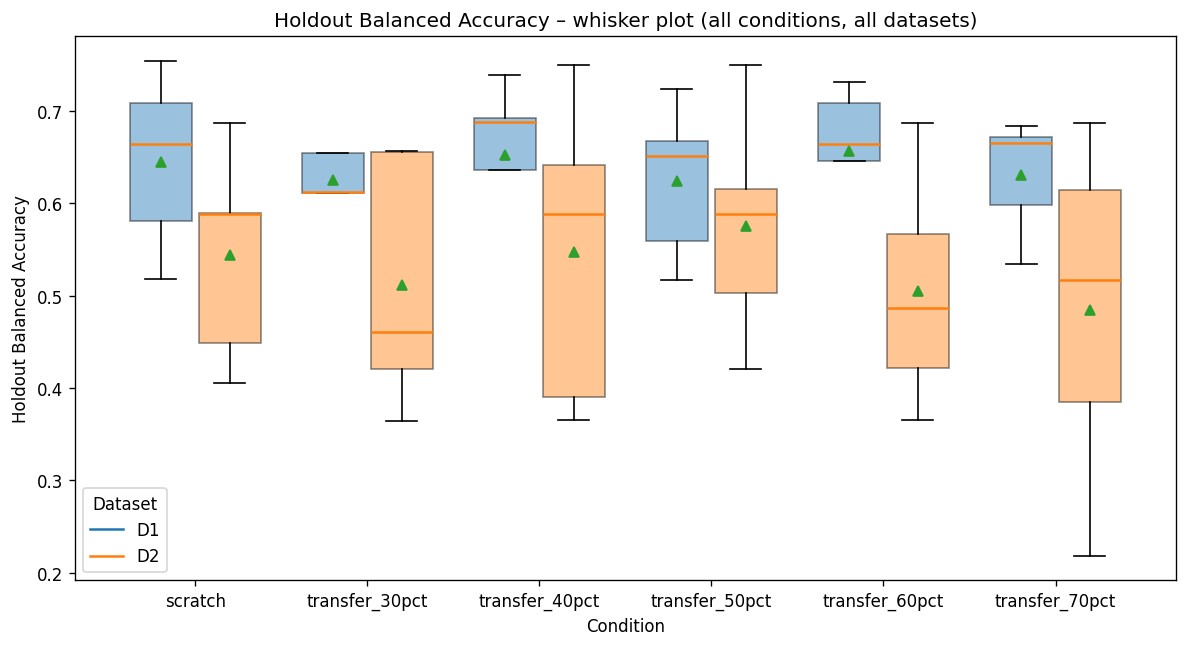

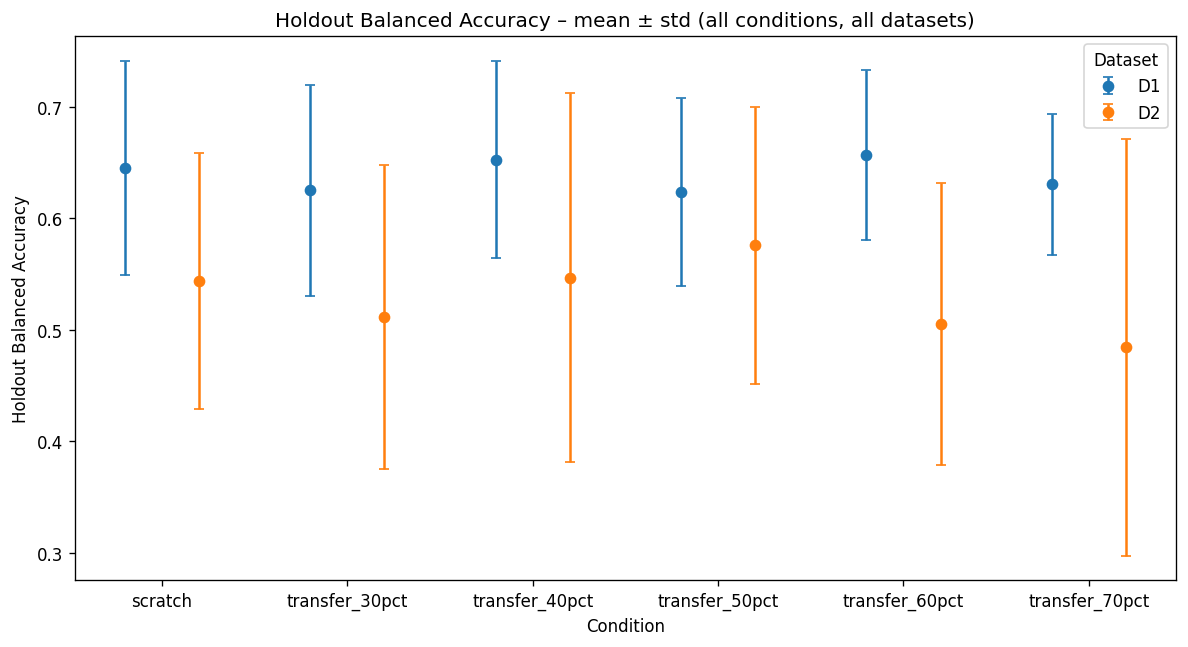

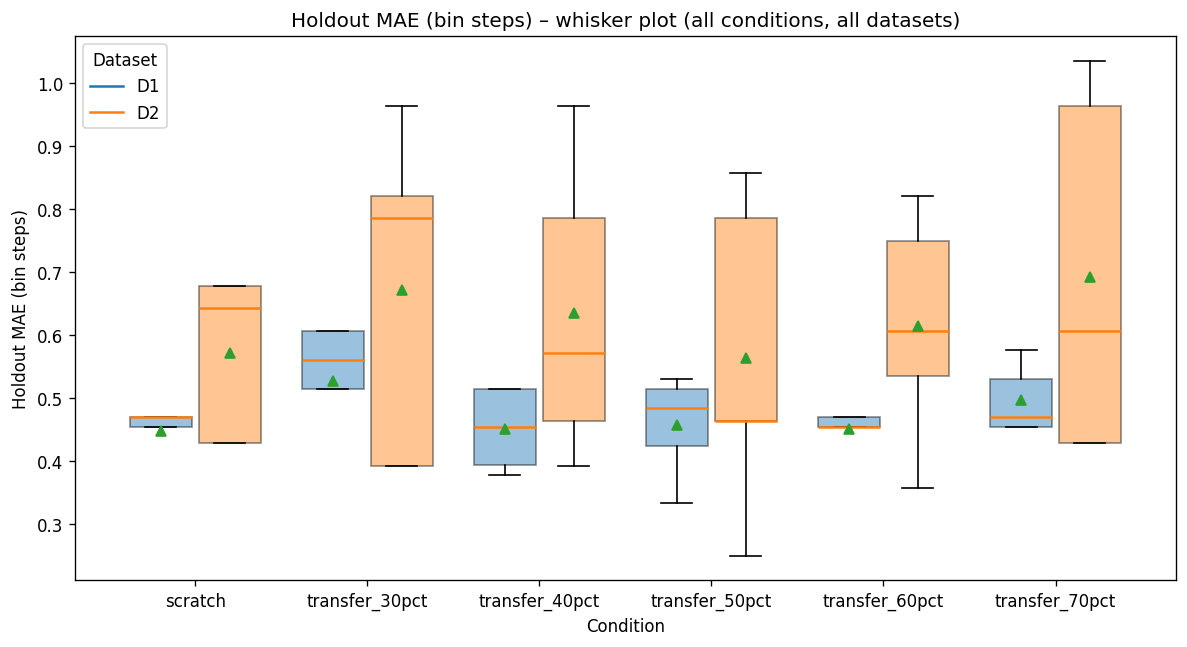

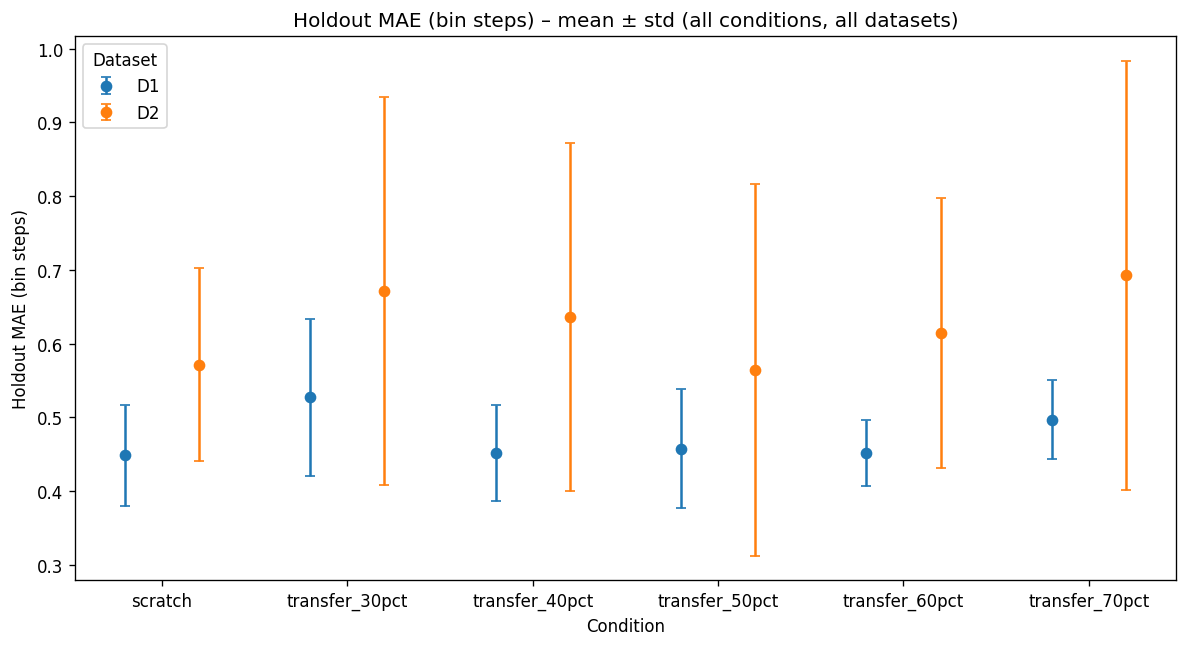

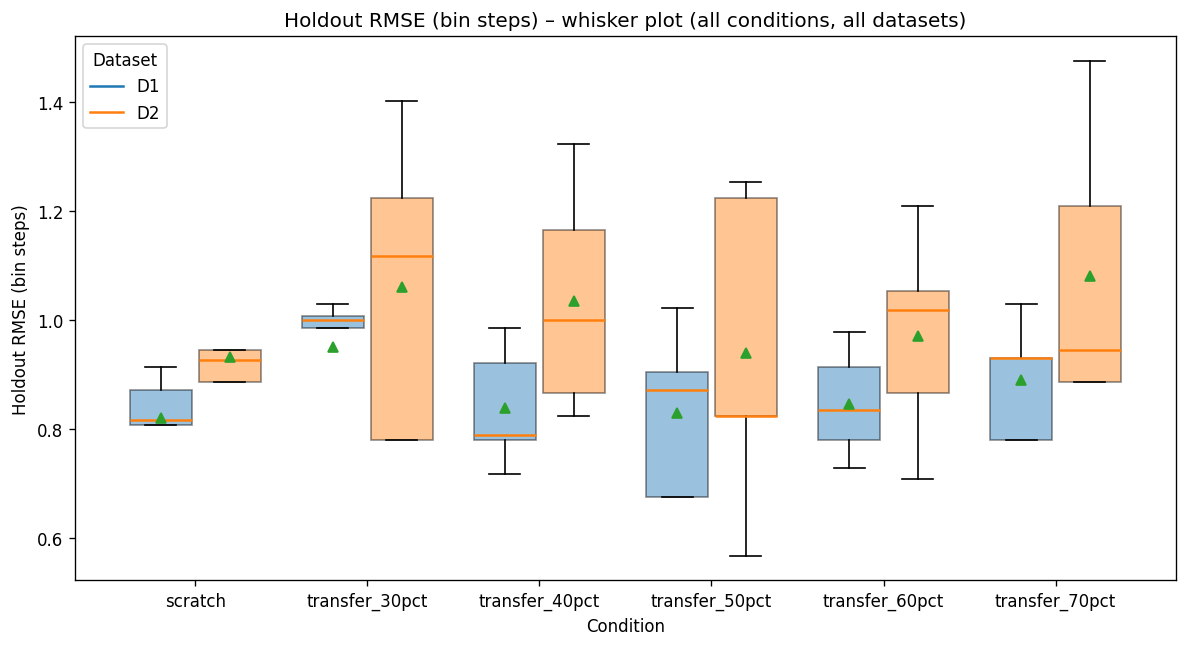

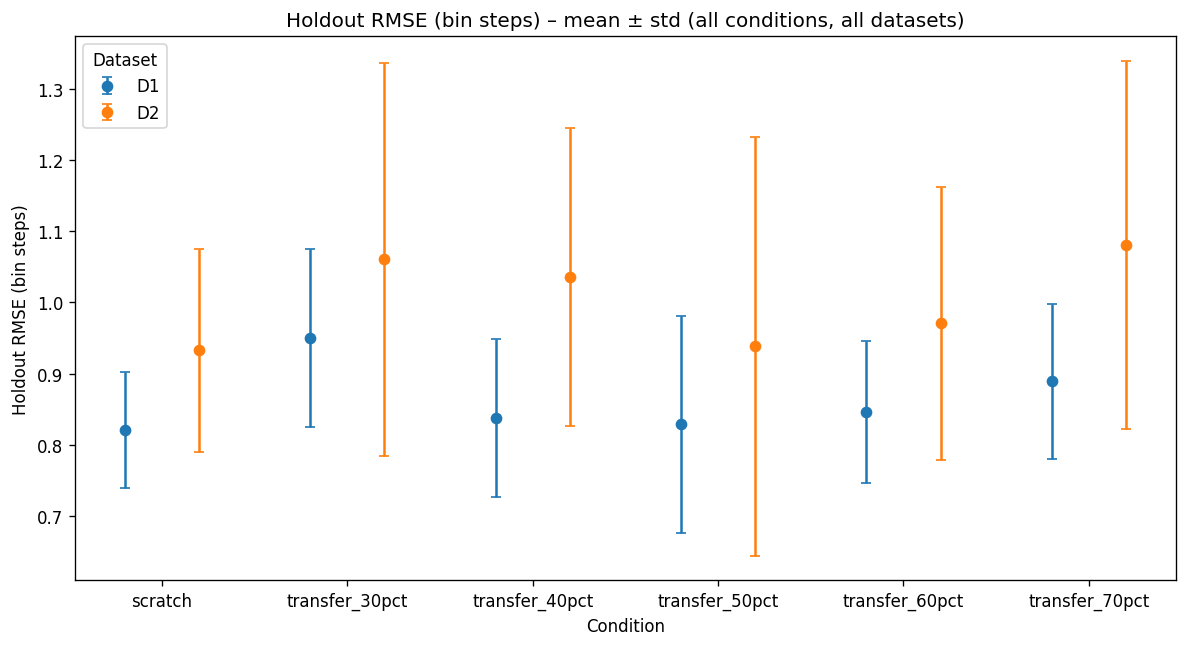


Saved plots to: transfer_learning_model_params/baseline/plots_combined_single


In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------ Config ------------------
SUMMARY_CSV = "transfer_learning_model_params/baseline/run_summary_across_seeds_and_pretrain_pct.csv"
OUTDIR = "transfer_learning_model_params/baseline/plots_combined_single"

SCRATCH_LABEL = "scratch"

# (column_name, plot_title, higher_is_better)  # higher_is_better not used here but kept if you want annotations later
METRICS = [
    ("holdout_bacc", "Holdout Balanced Accuracy", True),
    ("holdout_mae_bins", "Holdout MAE (bin steps)", False),
    ("holdout_rmse_bins", "Holdout RMSE (bin steps)", False),
]

SAVE_FIGS = True
SHOW_FIGS = True

plt.rcParams["figure.dpi"] = 120


# ------------------ Helpers ------------------
def ensure_dir(path):
    os.makedirs(path, exist_ok=True)

def _to_float_or_nan(x):
    try:
        return float(x)
    except Exception:
        return np.nan

def clean(df):
    df = df.copy()

    # normalize pretrain_pct
    df["pretrain_pct"] = df["pretrain_pct"].fillna(SCRATCH_LABEL)
    df["pretrain_pct_str"] = df["pretrain_pct"].astype(str).str.strip().str.lower()

    # numeric pct for sorting/labels
    df["pretrain_pct_num"] = df["pretrain_pct_str"].replace(SCRATCH_LABEL, np.nan).apply(_to_float_or_nan)

    # make a single "condition" label we can plot
    def cond_label(row):
        if row["pretrain_pct_str"] == SCRATCH_LABEL:
            return "scratch"
        # show 0.6 -> 60%
        if pd.notna(row["pretrain_pct_num"]):
            return f"transfer_{int(round(row['pretrain_pct_num']))}pct"
        return f"transfer_{row['pretrain_pct_str']}"

    df["condition"] = df.apply(cond_label, axis=1)

    if "random_state" not in df.columns:
        df["random_state"] = 0

    return df

def condition_order(df):
    """
    scratch first, then transfer in ascending %.
    """
    conds = df["condition"].dropna().unique().tolist()

    scratch = [c for c in conds if c == "scratch"]
    transfers = [c for c in conds if c.startswith("transfer_")]

    def pct_from_cond(c):
        # transfer_60pct -> 60
        s = c.replace("transfer_", "").replace("pct", "")
        try:
            return int(s)
        except Exception:
            return 999999

    transfers_sorted = sorted(transfers, key=pct_from_cond)
    return scratch + transfers_sorted

def dataset_order(df):
    return sorted(df["dataset"].dropna().unique().tolist())


# ------------------ Plotters ------------------
def plot_whisker_single(df, metric, title, outdir=None):
    """
    ONE plot per metric:
      - x axis: condition (scratch, transfer_60pct, transfer_70pct, ...)
      - within each condition: side-by-side boxplots per dataset
    """
    conds = condition_order(df)
    dsets = dataset_order(df)

    # Prepare data as nested lists: [condition][dataset] -> array of values
    values = {}
    for c in conds:
        values[c] = {}
        for d in dsets:
            vals = df.loc[(df["condition"] == c) & (df["dataset"] == d), metric].dropna().values
            values[c][d] = vals

    # Figure
    plt.figure(figsize=(10, 5.5))

    # Layout parameters for grouped boxplots
    n_cond = len(conds)
    n_ds = len(dsets)

    group_x = np.arange(n_cond)  # one group per condition
    total_width = 0.80
    box_width = total_width / max(n_ds, 1)

    # Use default color cycle; each dataset gets one color
    for j, d in enumerate(dsets):
        # positions offset within each group
        positions = group_x - (total_width / 2) + (j + 0.5) * box_width

        data_for_boxes = [values[c][d] for c in conds]

        bp = plt.boxplot(
            data_for_boxes,
            positions=positions,
            widths=box_width * 0.90,
            patch_artist=True,
            showmeans=True,     # mean marker inside box
            showfliers=False,   # optional: hide extreme fliers for readability
        )

        # color boxes for this dataset consistently (matplotlib default color cycle)
        color = f"C{j}"
        for box in bp["boxes"]:
            box.set_facecolor(color)
            box.set_alpha(0.45)

        for med in bp["medians"]:
            med.set_linewidth(1.5)

        # label once per dataset using an invisible line
        plt.plot([], [], color=color, label=d)

    plt.title(f"{title} – whisker plot (all conditions, all datasets)")
    plt.ylabel(title)
    plt.xlabel("Condition")
    plt.xticks(group_x, conds, rotation=0)
    plt.legend(title="Dataset", loc="best")
    plt.tight_layout()

    if outdir:
        plt.savefig(os.path.join(outdir, f"whisker__{metric}.png"))

    if SHOW_FIGS:
        plt.show()
    else:
        plt.close()


def plot_mean_single(df, metric, title, outdir=None):
    """
    ONE plot per metric:
      - x axis: condition
      - within each condition: mean ± std per dataset (offset points with error bars)
    """
    conds = condition_order(df)
    dsets = dataset_order(df)

    # Compute stats
    stats = (
        df.groupby(["dataset", "condition"])[metric]
        .agg(["mean", "std", "count"])
        .reset_index()
    )

    plt.figure(figsize=(10, 5.5))

    n_cond = len(conds)
    n_ds = len(dsets)

    group_x = np.arange(n_cond)
    total_width = 0.80
    point_width = total_width / max(n_ds, 1)

    for j, d in enumerate(dsets):
        color = f"C{j}"
        x = []
        y = []
        yerr = []

        for i, c in enumerate(conds):
            row = stats[(stats["dataset"] == d) & (stats["condition"] == c)]
            if len(row) == 0:
                m, s = np.nan, np.nan
            else:
                m = float(row["mean"].iloc[0])
                s = float(row["std"].iloc[0]) if not pd.isna(row["std"].iloc[0]) else 0.0

            xpos = group_x[i] - (total_width / 2) + (j + 0.5) * point_width
            x.append(xpos)
            y.append(m)
            yerr.append(s)

        plt.errorbar(x, y, yerr=yerr, fmt="o", capsize=3, label=d)

    plt.title(f"{title} – mean ± std (all conditions, all datasets)")
    plt.ylabel(title)
    plt.xlabel("Condition")
    plt.xticks(group_x, conds, rotation=0)
    plt.legend(title="Dataset", loc="best")
    plt.tight_layout()

    if outdir:
        plt.savefig(os.path.join(outdir, f"mean_std__{metric}.png"))

    if SHOW_FIGS:
        plt.show()
    else:
        plt.close()


# ------------------ Main ------------------
def main():
    ensure_dir(OUTDIR)

    df = pd.read_csv(SUMMARY_CSV)
    df = clean(df)

    # Basic guard
    if "dataset" not in df.columns:
        raise ValueError("CSV must contain a 'dataset' column.")
    if "condition" not in df.columns:
        raise ValueError("Condition column not created; check preprocessing.")

    for metric, title, _hib in METRICS:
        if metric not in df.columns:
            print(f"[WARN] Missing column '{metric}' – skipping")
            continue

        # Whisker (box) plot: ALL balanced acc (or MAE / RMSE) on one plot
        plot_whisker_single(df, metric, title, outdir=OUTDIR if SAVE_FIGS else None)

        # Mean ± std plot: ALL conditions on one plot
        plot_mean_single(df, metric, title, outdir=OUTDIR if SAVE_FIGS else None)

    if SAVE_FIGS:
        print(f"\nSaved plots to: {OUTDIR}")


if __name__ == "__main__":
    main()


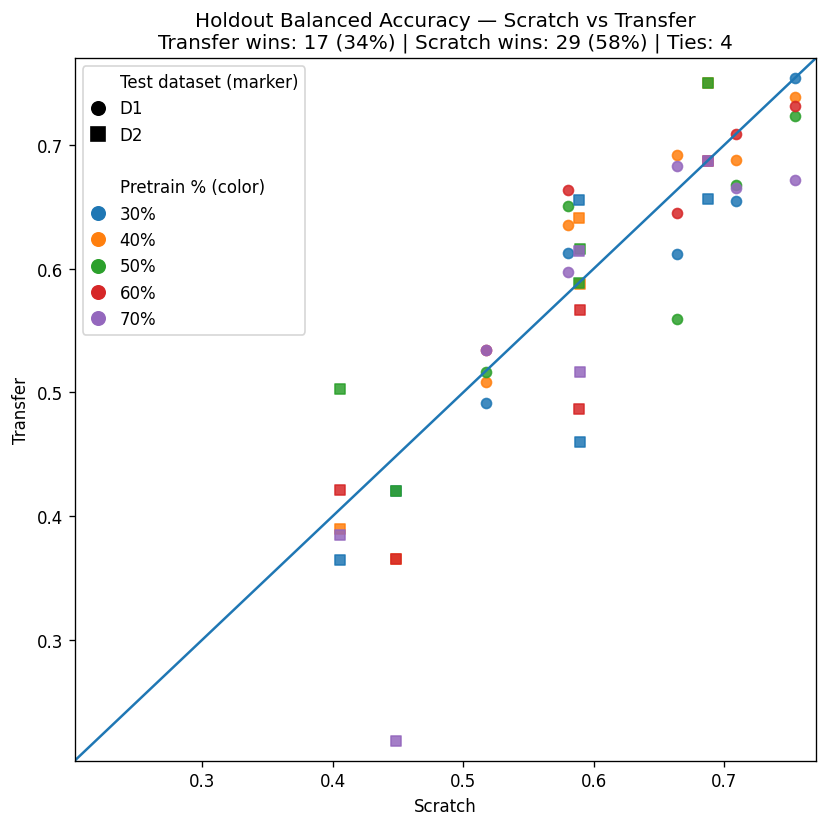

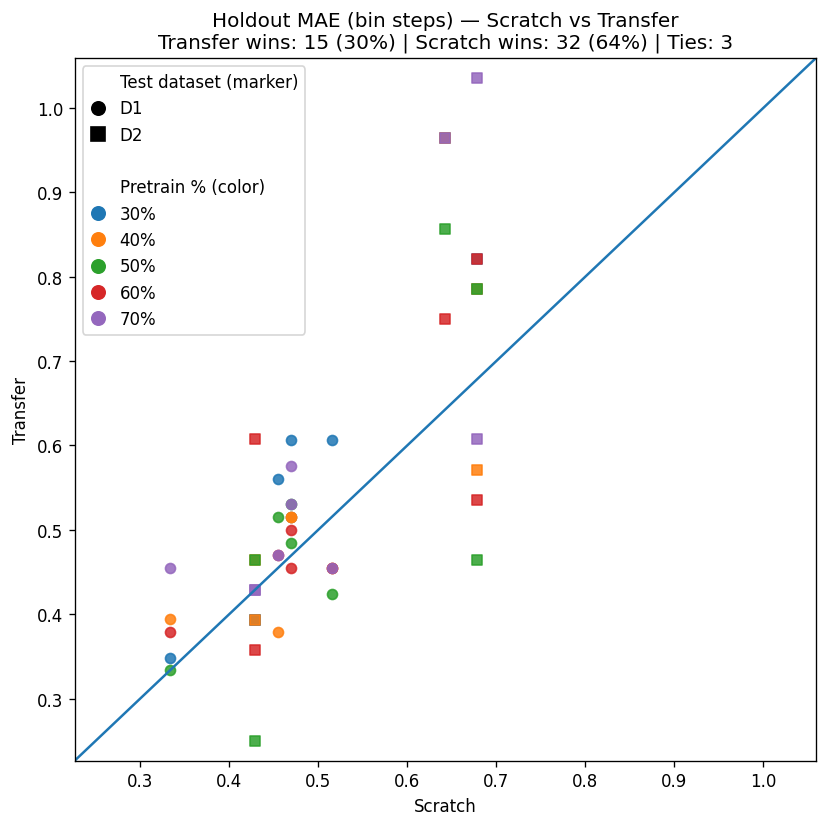

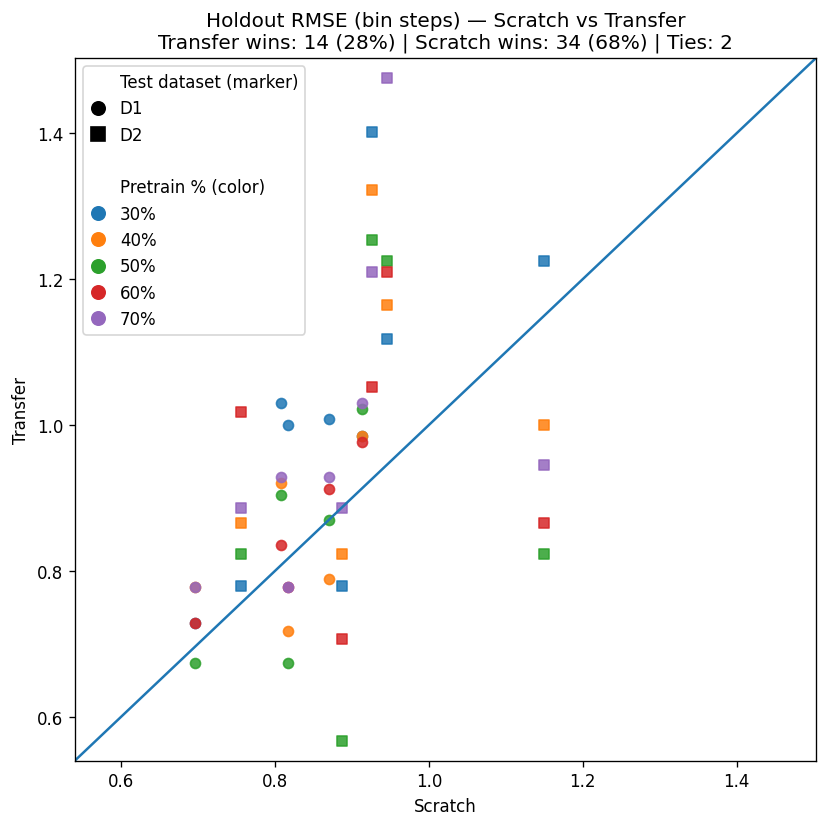


Saved VS plots to: transfer_learning_model_params/baseline/plots_vs_only


In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ------------------ Config ------------------
SUMMARY_CSV = "transfer_learning_model_params/baseline/run_summary_across_seeds_and_pretrain_pct.csv"
OUTDIR = "transfer_learning_model_params/baseline/plots_vs_only"

SCRATCH_LABEL = "scratch"

METRICS = [
    ("holdout_bacc", "Holdout Balanced Accuracy", True),
    ("holdout_mae_bins", "Holdout MAE (bin steps)", False),
    ("holdout_rmse_bins", "Holdout RMSE (bin steps)", False),
]

SAVE_FIGS = True
SHOW_FIGS = True

plt.rcParams["figure.dpi"] = 120


# ------------------ Helpers ------------------
def ensure_dir(path):
    os.makedirs(path, exist_ok=True)


def _to_float_or_nan(x):
    try:
        return float(x)
    except Exception:
        return np.nan


def clean(df):
    df = df.copy()

    df["pretrain_pct"] = df["pretrain_pct"].fillna(SCRATCH_LABEL)
    df["pretrain_pct_str"] = df["pretrain_pct"].astype(str).str.lower()
    df["pretrain_pct_num"] = (
        df["pretrain_pct_str"]
        .replace(SCRATCH_LABEL, np.nan)
        .apply(_to_float_or_nan)
    )

    def cond_label(row):
        if row["pretrain_pct_str"] == SCRATCH_LABEL:
            return "scratch"
        return f"transfer_{int(round(row['pretrain_pct_num']))}pct"

    df["condition"] = df.apply(cond_label, axis=1)

    if "random_state" not in df.columns:
        df["random_state"] = 0

    return df


def paired_table(df, metric):
    scratch = (
        df[df["condition"] == "scratch"]
        [["dataset", "random_state", metric]]
        .rename(columns={metric: "scratch"})
        .drop_duplicates()
    )

    transfer = (
        df[df["condition"] != "scratch"]
        [["dataset", "random_state", "condition", metric]]
        .rename(columns={metric: "transfer"})
        .drop_duplicates()
    )

    paired = transfer.merge(
        scratch,
        on=["dataset", "random_state"],
        how="inner",
    )

    return paired


def compute_vs_counts(paired, higher_is_better):
    if higher_is_better:
        transfer_wins = (paired["transfer"] > paired["scratch"]).sum()
        scratch_wins = (paired["transfer"] < paired["scratch"]).sum()
    else:
        transfer_wins = (paired["transfer"] < paired["scratch"]).sum()
        scratch_wins = (paired["transfer"] > paired["scratch"]).sum()

    ties = (paired["transfer"] == paired["scratch"]).sum()
    total = len(paired)

    return {
        "transfer": int(transfer_wins),
        "scratch": int(scratch_wins),
        "ties": int(ties),
        "total": int(total),
        "transfer_pct": (transfer_wins / total) if total else 0.0,
        "scratch_pct": (scratch_wins / total) if total else 0.0,
    }


# ------------------ VS Plot ------------------
def plot_vs_single(paired, metric_title, higher_is_better, outdir=None):
    """
    Single VS plot per metric:
      x = scratch
      y = transfer
      color = pretrain %
      marker = TEST / EVALUATION dataset
    """
    if paired.empty:
        print("[WARN] No paired rows found — skipping VS plot.")
        return

    test_datasets = sorted(paired["dataset"].unique())
    conditions = sorted(
        paired["condition"].unique(),
        key=lambda c: int(c.replace("transfer_", "").replace("pct", ""))
    )

    markers = ["o", "s", "^", "D", "P", "X"]
    ds_marker = {d: markers[i % len(markers)] for i, d in enumerate(test_datasets)}
    cond_color = {c: f"C{i}" for i, c in enumerate(conditions)}

    counts = compute_vs_counts(paired, higher_is_better)

    plt.figure(figsize=(7, 7))

    for d in test_datasets:
        for c in conditions:
            g = paired[(paired["dataset"] == d) & (paired["condition"] == c)]
            if g.empty:
                continue

            plt.scatter(
                g["scratch"],
                g["transfer"],
                marker=ds_marker[d],
                color=cond_color[c],
                alpha=0.85,
            )

    # Diagonal
    vals = np.r_[paired["scratch"].values, paired["transfer"].values]
    lo, hi = np.nanmin(vals), np.nanmax(vals)
    pad = 0.03 * (hi - lo)
    plt.plot([lo - pad, hi + pad], [lo - pad, hi + pad])
    plt.xlim(lo - pad, hi + pad)
    plt.ylim(lo - pad, hi + pad)

    plt.xlabel("Scratch")
    plt.ylabel("Transfer")
    plt.title(
        f"{metric_title} — Scratch vs Transfer\n"
        f"Transfer wins: {counts['transfer']} ({counts['transfer_pct']:.0%}) | "
        f"Scratch wins: {counts['scratch']} ({counts['scratch_pct']:.0%}) | "
        f"Ties: {counts['ties']}"
    )

    # ---- Single combined legend ----
    legend_handles = []
    legend_labels = []

    legend_handles.append(Line2D([], [], linestyle="none"))
    legend_labels.append("Test dataset (marker)")

    for d in test_datasets:
        legend_handles.append(
            Line2D([], [], linestyle="none", marker=ds_marker[d], color="black", markersize=8)
        )
        legend_labels.append(str(d))

    legend_handles.append(Line2D([], [], linestyle="none"))
    legend_labels.append("")

    legend_handles.append(Line2D([], [], linestyle="none"))
    legend_labels.append("Pretrain % (color)")

    for c in conditions:
        lbl = c.replace("transfer_", "").replace("pct", "%")
        legend_handles.append(
            Line2D([], [], linestyle="none", marker="o", color=cond_color[c], markersize=8)
        )
        legend_labels.append(lbl)

    plt.legend(
        legend_handles,
        legend_labels,
        loc="best",
        frameon=True,
        handlelength=1.0,
    )

    plt.tight_layout()

    if outdir:
        fname = metric_title.replace(" ", "_").lower()
        plt.savefig(os.path.join(outdir, f"vs__{fname}.png"))

    if SHOW_FIGS:
        plt.show()
    else:
        plt.close()


# ------------------ Main ------------------
def main():
    ensure_dir(OUTDIR)

    df = pd.read_csv(SUMMARY_CSV)
    df = clean(df)

    for metric, title, hib in METRICS:
        if metric not in df.columns:
            continue

        paired = paired_table(df, metric)
        plot_vs_single(paired, title, hib, outdir=OUTDIR if SAVE_FIGS else None)

    if SAVE_FIGS:
        print(f"\nSaved VS plots to: {OUTDIR}")


if __name__ == "__main__":
    main()
